# MIT License

Copyright (c) 2023 Ritesh Choudhary

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Abstract/Aim

We have a Hepatitis C Prediction Dataset, that contains laboratory values of blood donors and Hepatitis C patients and demographic values like age. The data was obtained from UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/HCV+data

In this assignment we aim to create a complete ML project with

* Checking Data Quality
* Feature Selection
* Modeling - Training Models, Selecting Best Model, Hyperparameter Tuning
* Model Interpretibility
* Reports and Visualizations

# Variable Description

All attributes except Category and Sex are numerical.
Attributes 1 to 4 refer to the data of the patient:

1. X (Patient ID/No.)
2. Category (diagnosis) (values: '0=Blood Donor', '0s=suspect Blood Donor', '1=Hepatitis', '2=Fibrosis', '3=Cirrhosis')
3. Age (in years)
4. Sex (f,m)
Attributes 5 to 14 refer to laboratory data:
5. ALB
6. ALP
7. ALT
8. AST
9. BIL
10. CHE
11. CHOL
12. CREA
13. GGT
14. PROT

The target attribute for classification is Category (2): blood donors vs. Hepatitis C patients (including its progress ('just' Hepatitis C, Fibrosis, Cirrhosis).

In [1]:
##Installing all the required libraries for the Assignment
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future
!pip install h2o
!pip install fitter

import csv
import json
import logging
import optparse
import os
import random
import sys
import time
from datetime import datetime
from distutils.util import strtobool

# Importing all the libararies required for the assignment
import h2o
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
from h2o.automl import H2OAutoML
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch
from matplotlib.pyplot import figure

sns.set(rc={"figure.figsize": (16, 8)})

# Data Imputation
!pip install fancyimpute
from fancyimpute import IterativeImputer as MICE

# Model Interpretation
!pip install shap
import shap
from sklearn.model_selection import train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 MB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.40.0.3-py2.py3-none-any.whl size=177694727 sha256=25ccc51d48e815aa54f221e137106515ac6fbe4dbaec3f300c44e787845fefbe
  Stored in directory: /root/.cache/pip/wheels/9a/54/b6/c9ab3e71309ef0000bbe39e715020dc151bbfc557784b7f4c9
Successfully built h2o
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

## What question are you trying to answer? How did you frame it as an ML task?

Here I am trying to predict the presence of Hepatitis C or not. The presence of Hepatitis C is denoted by 1, else its 0, also the different kind of disease like Fibrosis and Cirhosis is denoted by 2 and 3. This is a classical classification problem. 

## What is human-level performance on that task? What level of performance is needed?

The various features are the laboratory data obtained from the tests. Taking a test is already a laborious process and interpreting its results by the doctor is the humsn intervention that is inovled as of mow. I am trying to automate this process with the help of Machine learning algorithms that can help to reduce human intervention.

The level of performance, i.e, accuracy needs to be really high as medical data is sensitive and outputing correct results is absolutely necessary in the field of healthcare.

In [2]:
# Importing the dataset
df = pd.read_csv("https://raw.githubusercontent.com/Riteshch-123/Data-Science-engg/main/HepatitisCdata.csv")
df.head()

,Unnamed: 0,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,1,0=Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,2,0=Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,3,0=Blood Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,4,0=Blood Donor,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,5,0=Blood Donor,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


## Where did the feature data and label come from?

The data was obtained from UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/HCV+data. 

All attributes except Category and Sex are numerical.
Attributes 1 to 4 refer to the data of the patient:

1. X (Patient ID/No.)
2. Category (diagnosis) (values: '0=Blood Donor', '0s=suspect Blood Donor', '1=Hepatitis', '2=Fibrosis', '3=Cirrhosis')
3. Age (in years)
4. Sex (f,m)
Attributes 5 to 14 refer to laboratory data:
5. ALB
6. ALP
7. ALT
8. AST
9. BIL
10. CHE
11. CHOL
12. CREA
13. GGT
14. PROT

# Explorartory Data Analysis & Feature Engineering

In [4]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# Checking distribution for nulls
nulls = df.isnull().sum().sort_values(ascending=False)
columns = nulls[nulls.values>0].index
fig = make_subplots(rows=5, cols=1, subplot_titles=columns)

for i, col in enumerate(columns):
    fig.add_trace(go.Histogram(x=df[col], name=col),\
                  row=i+1, col=1)
    
fig.update_layout(height=1080)
fig.show()

It looks that there are few outliers in ALP column starts to appear after 
```ALP=150```.
So we can impute nulls in this column either using median (robust to outliers) or mean of values before 150.

CHOL & ALB: are normally distributed, so we can fill null values with mean.

ALT is highly right skewed, it's better to use median imputation.

PROT is slightly left skewed, we can just fill nulls with median.

In [5]:
# Imputing the nulls 
df['ALP'] = df['ALP'].fillna(value=df.ALT.median())
df['CHOL'] = df['CHOL'].fillna(value=df.CHOL.mean())
df['ALB'] = df['ALB'].fillna(value=df.ALB.mean())
df['PROT'] = df['PROT'].fillna(value=df.PROT.mean())
df['ALT'] = df['ALT'].fillna(value=df.ALT.median())

print(f'Number of Nulls in our dataframe = {df.isnull().sum().sum()}')

Number of Nulls in our dataframe = 0


In [6]:
# Let's drop the unnecessary initial feature
df = df.drop(['Unnamed: 0'], axis = 1)

In [7]:
# The columns of the dataset
df.columns

Index(['Category', 'Age', 'Sex', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE',
       'CHOL', 'CREA', 'GGT', 'PROT'],
      dtype='object')

In [8]:
# Chcecking summary statistics
df.describe()

,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
count,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000
mean,47.408130,41.620195,66.958537,28.441951,34.786341,11.396748,8.196634,5.368099,81.287805,39.533171,72.044137
std,10.055105,5.775920,26.757601,25.449889,33.090690,19.673150,2.205657,1.123466,49.756166,54.661071,5.398234
min,19.000000,14.900000,11.300000,0.900000,10.600000,0.800000,1.420000,1.430000,8.000000,4.500000,44.800000
25%,39.000000,38.800000,51.700000,16.400000,21.600000,5.300000,6.935000,4.620000,67.000000,15.700000,69.300000
50%,47.000000,41.900000,65.300000,23.000000,25.900000,7.300000,8.260000,5.310000,77.000000,23.300000,72.200000
75%,54.000000,45.200000,79.300000,33.050000,32.900000,11.200000,9.590000,6.055000,88.000000,40.200000,75.400000
max,77.000000,82.200000,416.600000,325.300000,324.000000,254.000000,16.410000,9.670000,1079.100000,650.900000,90.000000


In [9]:
# Letr change "Category" and "Sex" into binary features
df['Category'] = df['Category'].map({'0=Blood Donor': 0, '0s=suspect Blood Donor': 0, 
                                     "1=Hepatitis" : 1, "2=Fibrosis" : 1, "3=Cirrhosis" : 1})

df['Sex'] = df['Sex'].map({'m': 1, 'f': 2})

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >DEBUG> (47.40813008130081, 10.04692723721577)
[distfit] >INFO> [norm      ] [0.00 sec] [ks: 0.0385821] [loc=47.408 scale=10.047]
[distfit] >DEBUG> (19.0, 28.40813008130081)
[distfit] >INFO> [expon     ] [0.00 sec] [ks: 1.10847] [loc=19.000 scale=28.408]
[distfit] >DEBUG> (151187962.73070344, -4294967277.0, 4294967295.9999995)
[distfit] >INFO> [pareto    ] [0.00 sec] [ks: 1.10847] [loc=-4294967277.000 scale=4294967296.000]
[distfit] >DEBUG> (1.3400978730485127, 46.61352461815044, 8.910175773533277)
[distfit] >INFO> [dweibull  ] [0.01 sec] [ks: 0.0385821] [loc=46.614 scale=8.910]
[distfit] >DEBUG> (5131131.897294387, 47.407930257477254, 10.046835856553976)
[distfit] >INFO> [t         ] [0.14 sec] [ks: 0.0385821] [loc=47.408 scale=10.047]
[distfit] >DEBUG> (0.19402514846150581, 43.46751352128221, 9.433837110116205)
[distfit] >INFO> [genextreme] [0.14 sec] [ks: 0.00194497] [loc=43.468 scale=9.434]
[distfit] >DEBUG> (24.931570489743

(<Figure size 2000x1500 with 1 Axes>,
 <Axes: title={'center': '\ngenextreme(c=0.194025, loc=43.4675, scale=9.43384)'}, xlabel='Values', ylabel='Frequency'>)

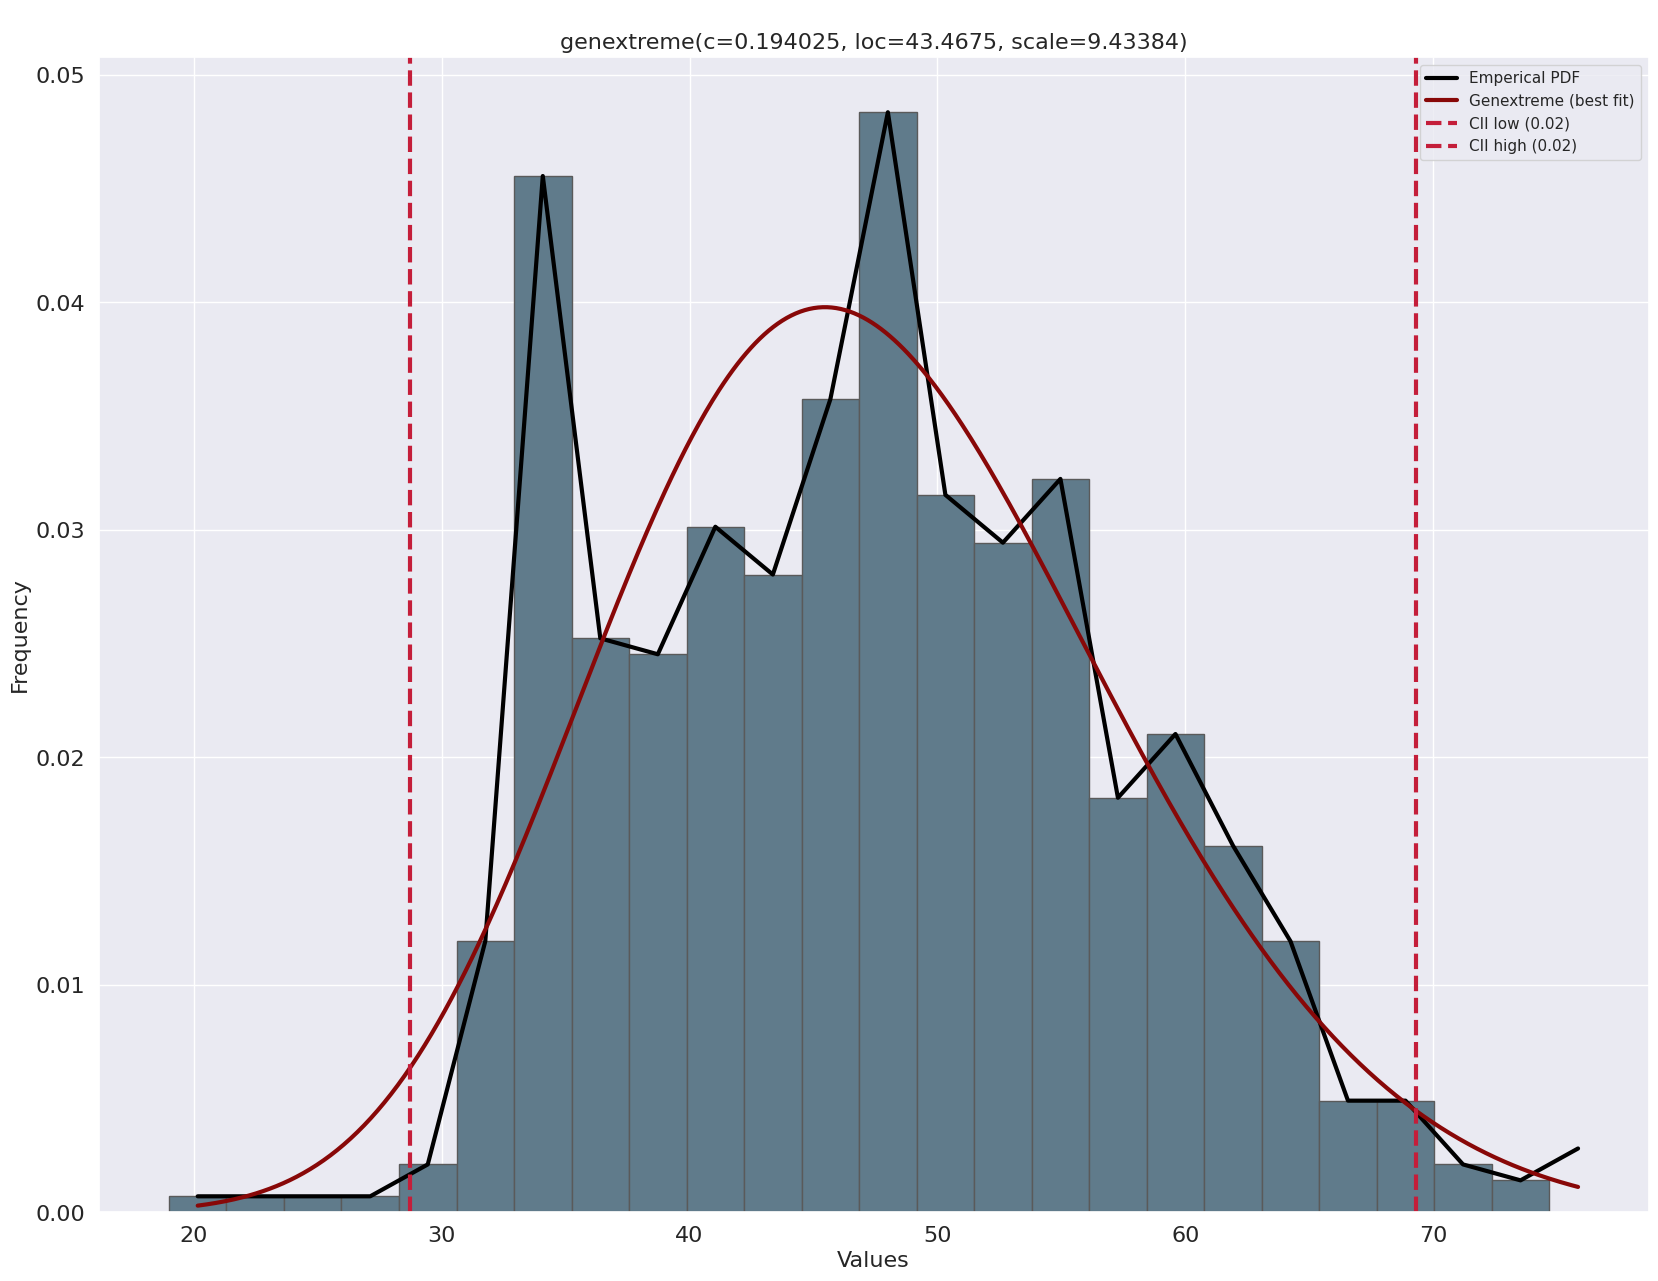

In [12]:
!pip install -U distfit
from distfit import distfit

# Plotting the distribution of AGE
age = distfit(bins=25, alpha = 0.02, stats = 'ks')
age.fit_transform(df['Age'], verbose = 1)
age.summary

age.plot(verbose=1)

As per the Metrics in the above table the given disttibution is likely to be Genetreme Distribution

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >DEBUG> (41.620195439739405, 5.771222352460544)
[distfit] >INFO> [norm      ] [0.00 sec] [ks: 0.322892] [loc=41.620 scale=5.771]
[distfit] >DEBUG> (14.9, 26.720195439739406)
[distfit] >INFO> [expon     ] [0.00 sec] [ks: 3.78909] [loc=14.900 scale=26.720]
[distfit] >DEBUG> (80369309.94663906, -2147483633.1, 2147483647.9999998)
[distfit] >INFO> [pareto    ] [0.00 sec] [ks: 3.78909] [loc=-2147483633.100 scale=2147483648.000]
[distfit] >DEBUG> (1.1128321411828015, 41.76344288411724, 4.304242515669806)
[distfit] >INFO> [dweibull  ] [0.01 sec] [ks: 0.322892] [loc=41.763 scale=4.304]
[distfit] >DEBUG> (4.017963542694184, 41.96101837719338, 4.084121275768398)
[distfit] >INFO> [t         ] [0.17 sec] [ks: 0.322892] [loc=41.961 scale=4.084]
[distfit] >DEBUG> (0.14080762665209018, 39.11176692296169, 6.527010011767021)
[distfit] >INFO> [genextreme] [0.28 sec] [ks: 0.322892] [loc=39.112 scale=6.527]
[distfit] >DEBUG> (567.0150667867979, -97.

(<Figure size 2000x1500 with 1 Axes>,
 <Axes: title={'center': '\nnorm(loc=41.6202, scale=5.77122)'}, xlabel='Values', ylabel='Frequency'>)

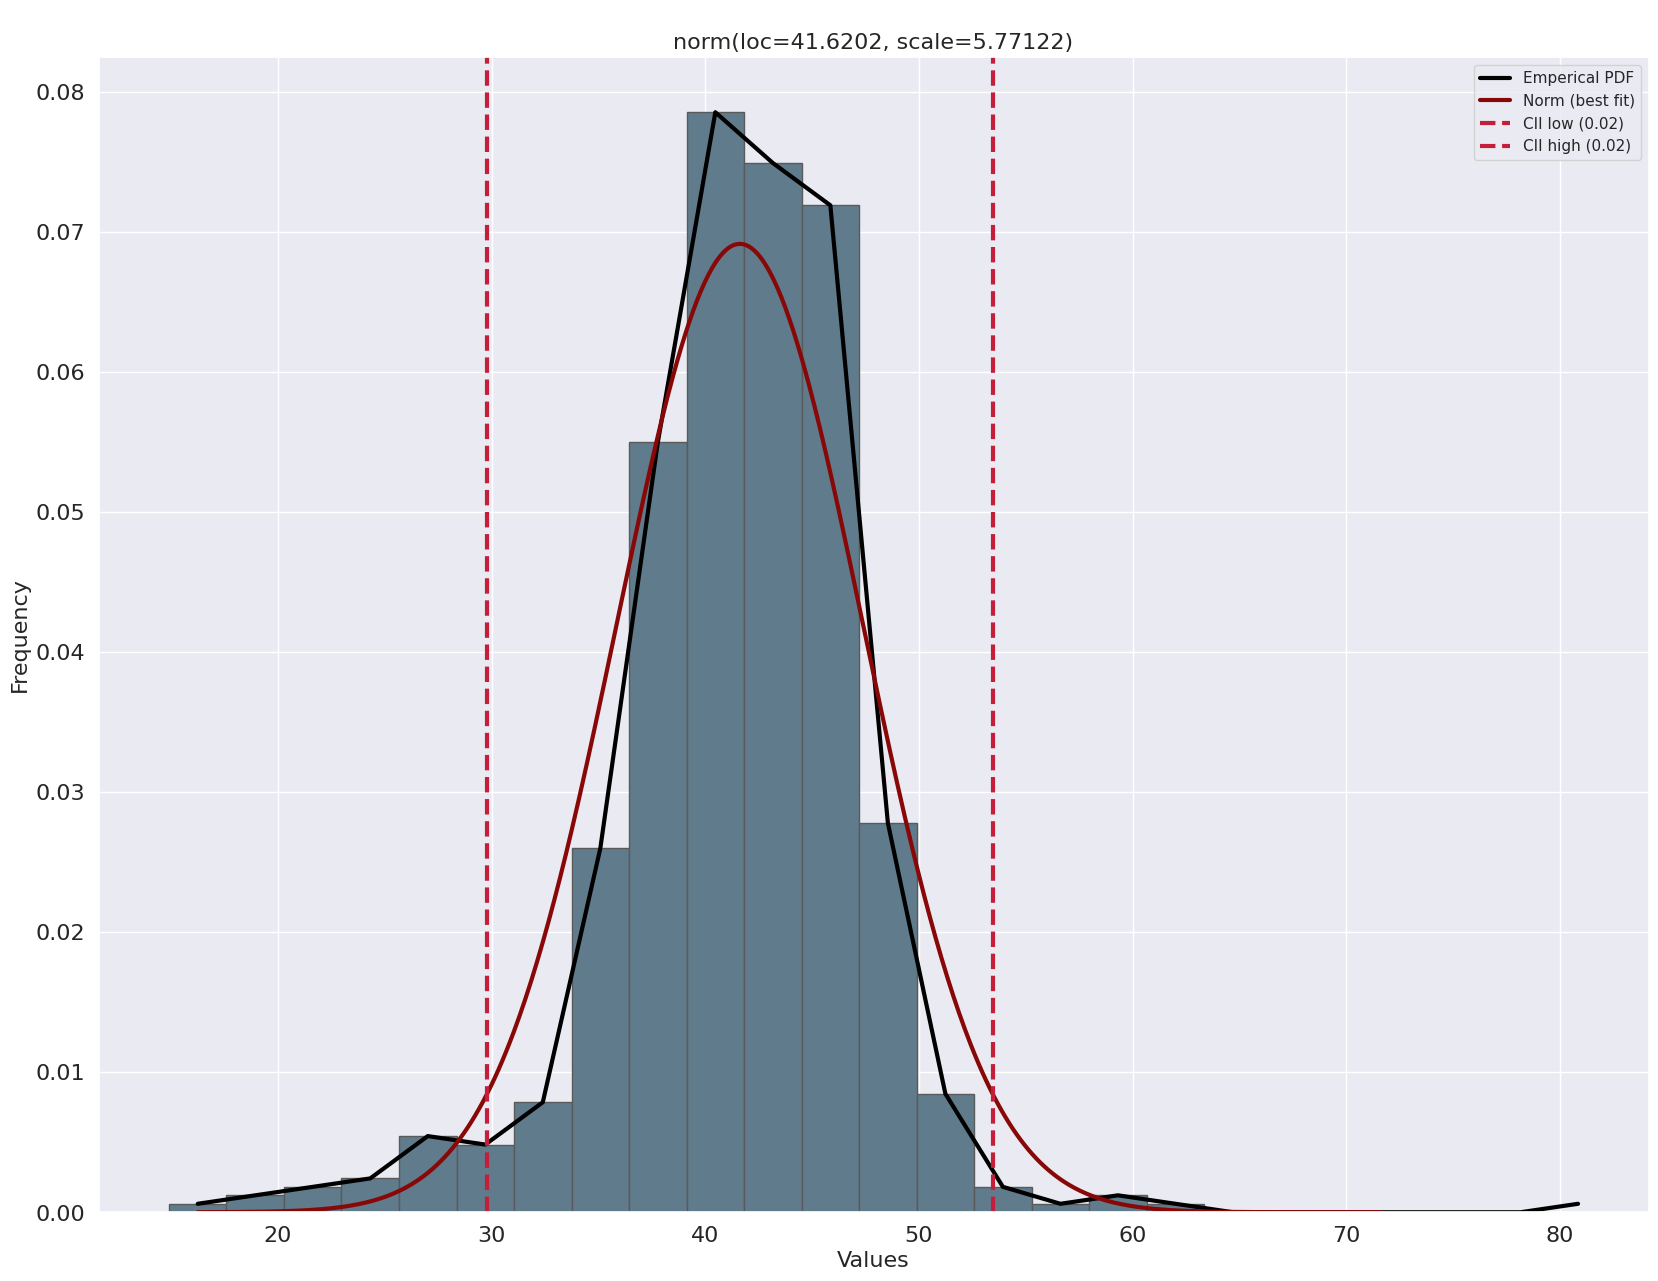

In [13]:
# Plotting the distribution of ALB
ALB = distfit(bins=25, alpha = 0.02, stats = 'ks')
ALB.fit_transform(df['ALB'], verbose = 1)
ALB.summary

ALB.plot(verbose=1)

As per the Metrics in the above table the given disttibution is likely to be Normal Distribution

In [14]:
# Plotting the distribution of ALP
ALP = distfit(bins=25, alpha = 0.02, stats = 'ks')
ALP.fit_transform(df['ALP'], verbose = 1)
ALP.summary

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >DEBUG> (66.95853658536585, 26.735837910054858)
[distfit] >INFO> [norm      ] [0.01 sec] [ks: 2.71654] [loc=66.959 scale=26.736]
[distfit] >DEBUG> (11.3, 55.65853658536585)
[distfit] >INFO> [expon     ] [0.00 sec] [ks: 2.71654] [loc=11.300 scale=55.659]
[distfit] >DEBUG> (77166372.10290094, -4294967284.7, 4294967295.9999995)
[distfit] >INFO> [pareto    ] [0.01 sec] [ks: 2.71654] [loc=-4294967284.700 scale=4294967296.000]
[distfit] >DEBUG> (1.098631227567586, 65.17419239361413, 18.334692142964165)
[distfit] >INFO> [dweibull  ] [0.07 sec] [ks: 2.71654] [loc=65.174 scale=18.335]
[distfit] >DEBUG> (4.927138840796514, 65.415965542306, 18.134284853973778)
[distfit] >INFO> [t         ] [0.52 sec] [ks: 2.71654] [loc=65.416 scale=18.134]
[distfit] >DEBUG> (0.0065938487763973755, 55.961776659547084, 20.449486415065827)
[distfit] >INFO> [genextreme] [0.78 sec] [ks: 2.71654] [loc=55.962 scale=20.449]
[distfit] >DEBUG> (8.532881914197667, -3

,name,score,loc,scale,arg,params,model,bootstrap_score,bootstrap_pass,color
0,norm,2.716536,66.958537,26.735838,(),"(66.95853658536585, 26.735837910054858)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
1,expon,2.716536,11.3,55.658537,(),"(11.3, 55.65853658536585)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
2,pareto,2.716536,-4294967284.7,4294967296.0,"(77166372.10290094,)","(77166372.10290094, -4294967284.7, 4294967295....",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#377eb8
3,dweibull,2.716536,65.174192,18.334692,"(1.098631227567586,)","(1.098631227567586, 65.17419239361413, 18.3346...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#4daf4a
4,t,2.716536,65.415966,18.134285,"(4.927138840796514,)","(4.927138840796514, 65.415965542306, 18.134284...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#984ea3
5,genextreme,2.716536,55.961777,20.449486,"(0.0065938487763973755,)","(0.0065938487763973755, 55.961776659547084, 20...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#ff7f00
6,gamma,2.716536,-3.63854,8.273533,"(8.532881914197667,)","(8.532881914197667, -3.638539642068918, 8.2735...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#ffff33
7,lognorm,2.716536,-29.67836,93.700759,"(0.24421771122995856,)","(0.24421771122995856, -29.67836011025233, 93.7...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#a65628
8,beta,2.716536,0.20576,269696683.834283,"(7.338158419062964, 29600726.398711264)","(7.338158419062964, 29600726.398711264, 0.2057...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#f781bf
9,loggamma,2.716536,-10741.037344,1377.861694,"(2550.737334619671,)","(2550.737334619671, -10741.037344025102, 1377....",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999


[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >DEBUG> (66.95853658536585, 26.735837910054858)
[distfit] >INFO> [norm      ] [0.00 sec] [ks: 2.71654] [loc=66.959 scale=26.736]
[distfit] >DEBUG> (11.3, 55.65853658536585)
[distfit] >INFO> [expon     ] [0.00 sec] [ks: 2.71654] [loc=11.300 scale=55.659]
[distfit] >DEBUG> (77166372.10290094, -4294967284.7, 4294967295.9999995)
[distfit] >INFO> [pareto    ] [0.02 sec] [ks: 2.71654] [loc=-4294967284.700 scale=4294967296.000]
[distfit] >DEBUG> (1.098631227567586, 65.17419239361413, 18.334692142964165)
[distfit] >INFO> [dweibull  ] [0.03 sec] [ks: 2.71654] [loc=65.174 scale=18.335]
[distfit] >DEBUG> (4.927138840796514, 65.415965542306, 18.134284853973778)
[distfit] >INFO> [t         ] [0.35 sec] [ks: 2.71654] [loc=65.416 scale=18.134]
[distfit] >DEBUG> (0.0065938487763973755, 55.961776659547084, 20.449486415065827)
[distfit] >INFO> [genextreme] [0.49 sec] [ks: 2.71654] [loc=55.962 scale=20.449]
[distfit] >DEBUG> (8.532881914197667, -3

(<Figure size 2000x1500 with 1 Axes>,
 <Axes: title={'center': '\nnorm(loc=66.9585, scale=26.7358)'}, xlabel='Values', ylabel='Frequency'>)

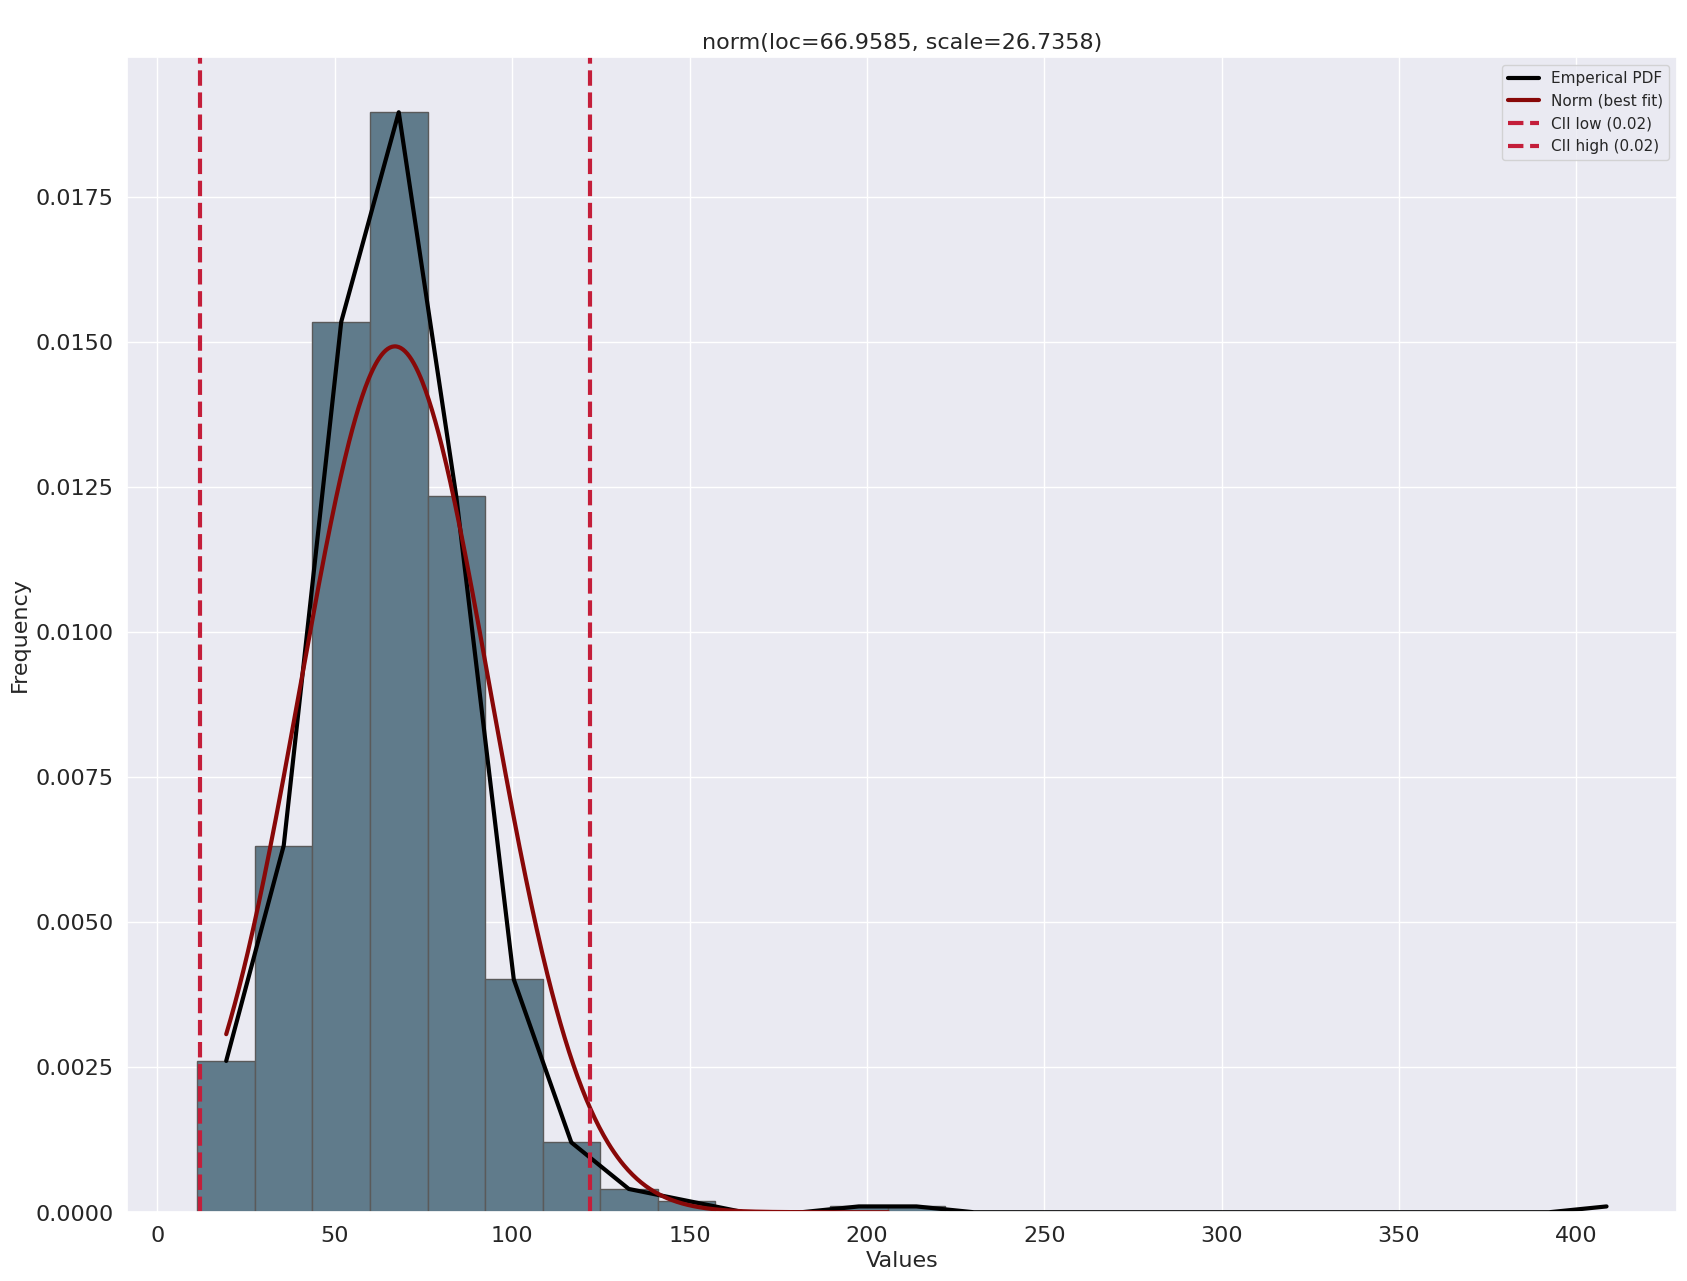

In [15]:
# Plotting the distribution of ALP
ALP = distfit(bins=25, alpha = 0.02, stats = 'ks')
ALP.fit_transform(df['ALP'], verbose = 1)
ALP.summary

ALP.plot(verbose=1)

As per the Metrics in the above table the given disttibution is likely to be Normal Distribution

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >DEBUG> (28.441951219512195, 25.42918934982966)
[distfit] >INFO> [norm      ] [0.00 sec] [ks: 1.82862] [loc=28.442 scale=25.429]
[distfit] >DEBUG> (0.9, 27.541951219512196)
[distfit] >INFO> [expon     ] [0.00 sec] [ks: 1.82862] [loc=0.900 scale=27.542]
[distfit] >DEBUG> (155942739.33381832, -4294967295.1, 4294967295.9999995)
[distfit] >INFO> [pareto    ] [0.02 sec] [ks: 1.82862] [loc=-4294967295.100 scale=4294967296.000]
[distfit] >DEBUG> (0.8708127899908094, 22.999999999999996, 11.952025546622357)
[distfit] >INFO> [dweibull  ] [0.15 sec] [ks: 1.82862] [loc=23.000 scale=11.952]
[distfit] >DEBUG> (1.9785931455483388, 22.441520387519496, 8.896802704254993)
[distfit] >INFO> [t         ] [0.17 sec] [ks: 1.82862] [loc=22.442 scale=8.897]
[distfit] >DEBUG> (-0.19322110041881024, 19.054160503932412, 10.950727012024753)
[distfit] >INFO> [genextreme] [0.16 sec] [ks: 1.82862] [loc=19.054 scale=10.951]
[distfit] >DEBUG> (0.6563314575565322

(<Figure size 2000x1500 with 1 Axes>,
 <Axes: title={'center': '\nnorm(loc=28.442, scale=25.4292)'}, xlabel='Values', ylabel='Frequency'>)

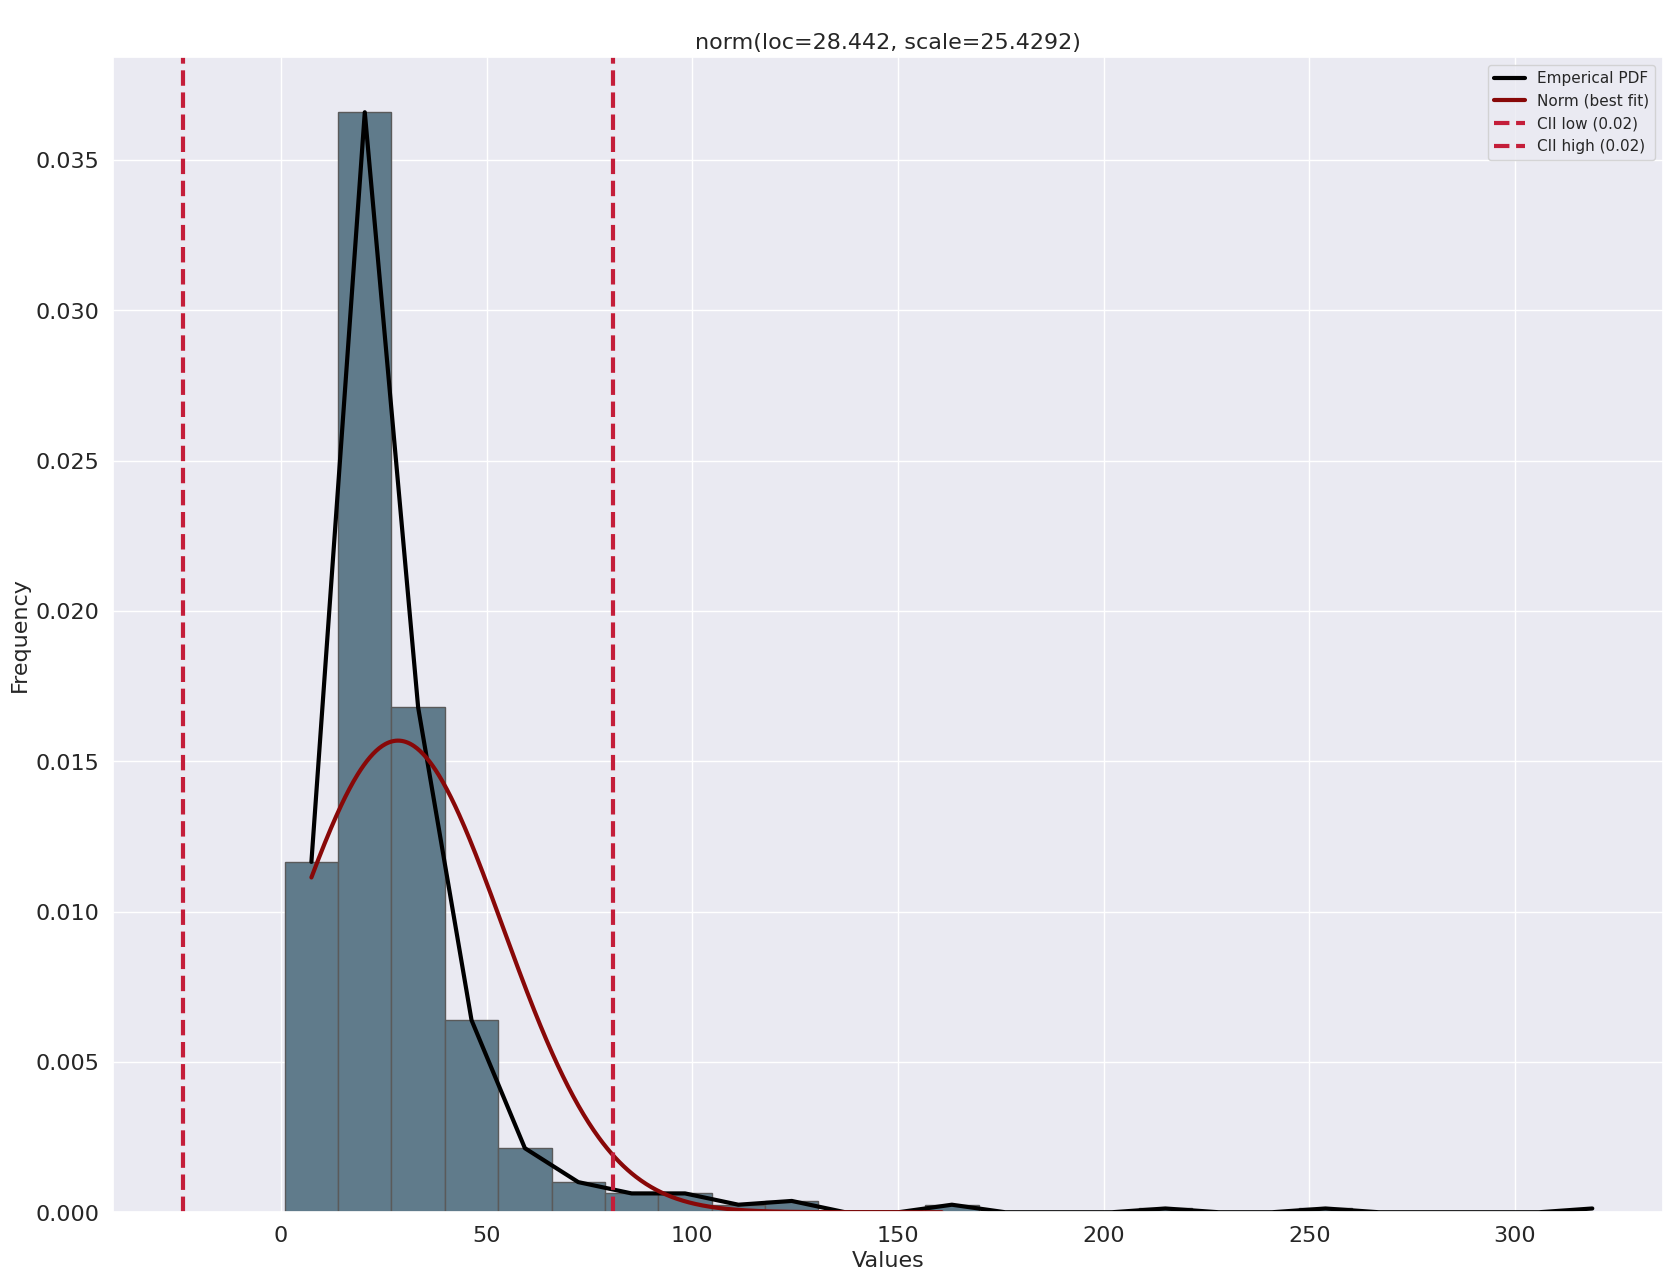

In [16]:
# Plotting the distribution of ALT
ALT = distfit(bins=25, alpha = 0.02, stats = 'ks')
ALT.fit_transform(df['ALT'], verbose = 1)
ALT.summary

ALT.plot(verbose=1)

As per the Metrics in the above table the given disttibution is likely to be Normal Distribution

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >DEBUG> (34.78634146341463, 33.063776393197095)
[distfit] >INFO> [norm      ] [0.00 sec] [ks: 0.807543] [loc=34.786 scale=33.064]
[distfit] >DEBUG> (10.6, 24.186341463414628)
[distfit] >INFO> [expon     ] [0.00 sec] [ks: 0.545091] [loc=10.600 scale=24.186]
[distfit] >DEBUG> (7.524174552735194, -145.21430741893968, 155.81430741893968)
[distfit] >INFO> [pareto    ] [0.00 sec] [ks: 0.545091] [loc=-145.214 scale=155.814]
[distfit] >DEBUG> (0.6705082129324615, 24.299999999999997, 9.284605768289913)
[distfit] >INFO> [dweibull  ] [0.04 sec] [ks: 1.10847] [loc=24.300 scale=9.285]
[distfit] >DEBUG> (1.2159201827908976, 25.10425248371144, 5.292788928649839)
[distfit] >INFO> [t         ] [0.30 sec] [ks: 1.10847] [loc=25.104 scale=5.293]
[distfit] >DEBUG> (-0.39513585100304427, 23.408941854816238, 7.94800749259626)
[distfit] >INFO> [genextreme] [0.38 sec] [ks: 0.545091] [loc=23.409 scale=7.948]
[distfit] >DEBUG> (0.07901869298474634, 10.599

(<Figure size 2000x1500 with 1 Axes>,
 <Axes: title={'center': '\nexpon(loc=10.6, scale=24.1863)'}, xlabel='Values', ylabel='Frequency'>)

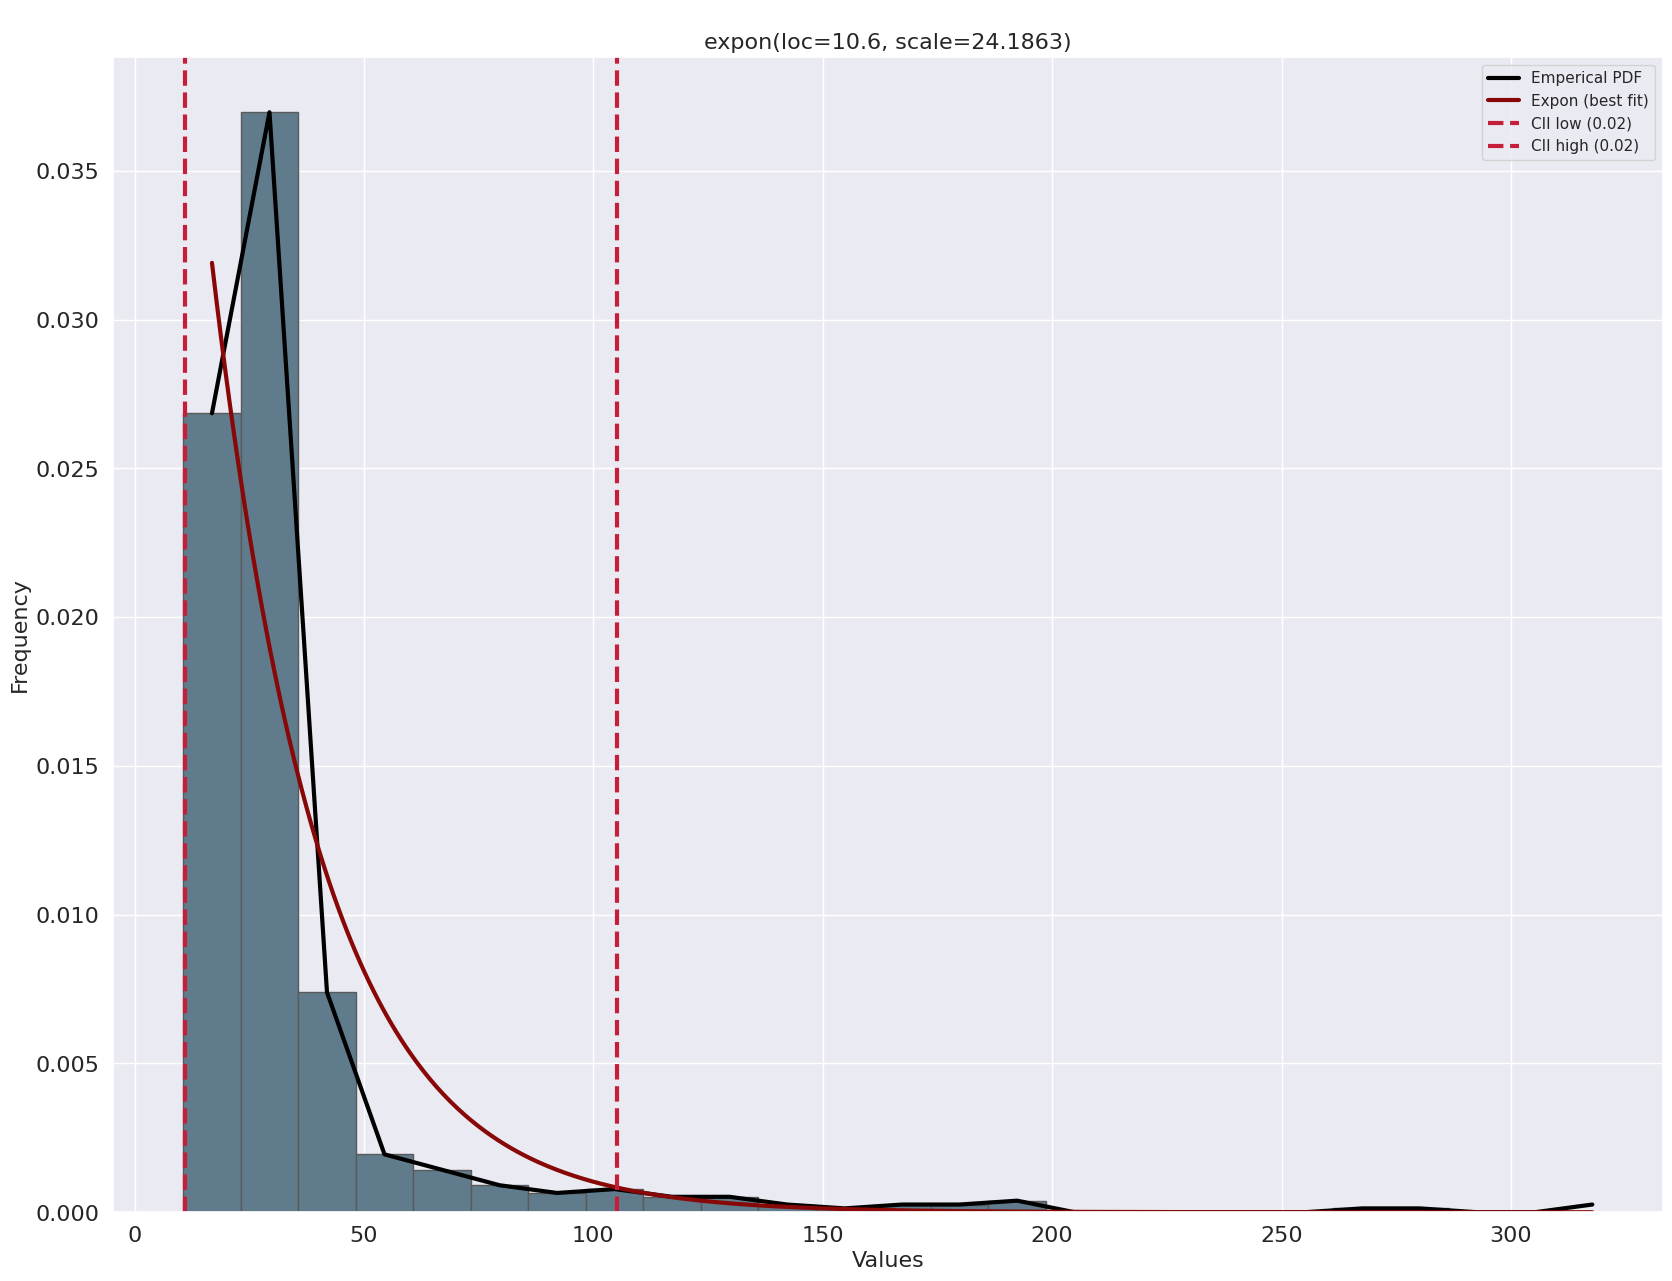

In [17]:
# Plotting the distribution of AST
AST = distfit(bins=25, alpha = 0.02, stats = 'ks')
AST.fit_transform(df['AST'], verbose = 1)
AST.summary

AST.plot(verbose=1)

As per the Metrics in the above table the given disttibution is likely to be Exponential Distribution

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >DEBUG> (11.396747967479675, 19.657148868017618)
[distfit] >INFO> [norm      ] [0.00 sec] [ks: 2.71654] [loc=11.397 scale=19.657]
[distfit] >DEBUG> (0.8, 10.596747967479674)
[distfit] >INFO> [expon     ] [0.00 sec] [ks: 2.71654] [loc=0.800 scale=10.597]
[distfit] >DEBUG> (6.187094678259109, -51.88254693810647, 52.68254693810647)
[distfit] >INFO> [pareto    ] [0.00 sec] [ks: 2.71654] [loc=-51.883 scale=52.683]
[distfit] >DEBUG> (0.6882964233489242, 7.000000000000001, 3.9150836696932863)
[distfit] >INFO> [dweibull  ] [0.06 sec] [ks: 2.71654] [loc=7.000 scale=3.915]
[distfit] >DEBUG> (1.4127186036507609, 6.995150204994902, 2.805112561666005)
[distfit] >INFO> [t         ] [0.08 sec] [ks: 2.71654] [loc=6.995 scale=2.805]
[distfit] >DEBUG> (-0.4177801889203644, 6.097045607158719, 3.465192273099319)
[distfit] >INFO> [genextreme] [0.19 sec] [ks: 2.71654] [loc=6.097 scale=3.465]
[distfit] >DEBUG> (1.333705341691736, 0.7916703092012525, 7

(<Figure size 2000x1500 with 1 Axes>,
 <Axes: title={'center': '\nnorm(loc=11.3967, scale=19.6571)'}, xlabel='Values', ylabel='Frequency'>)

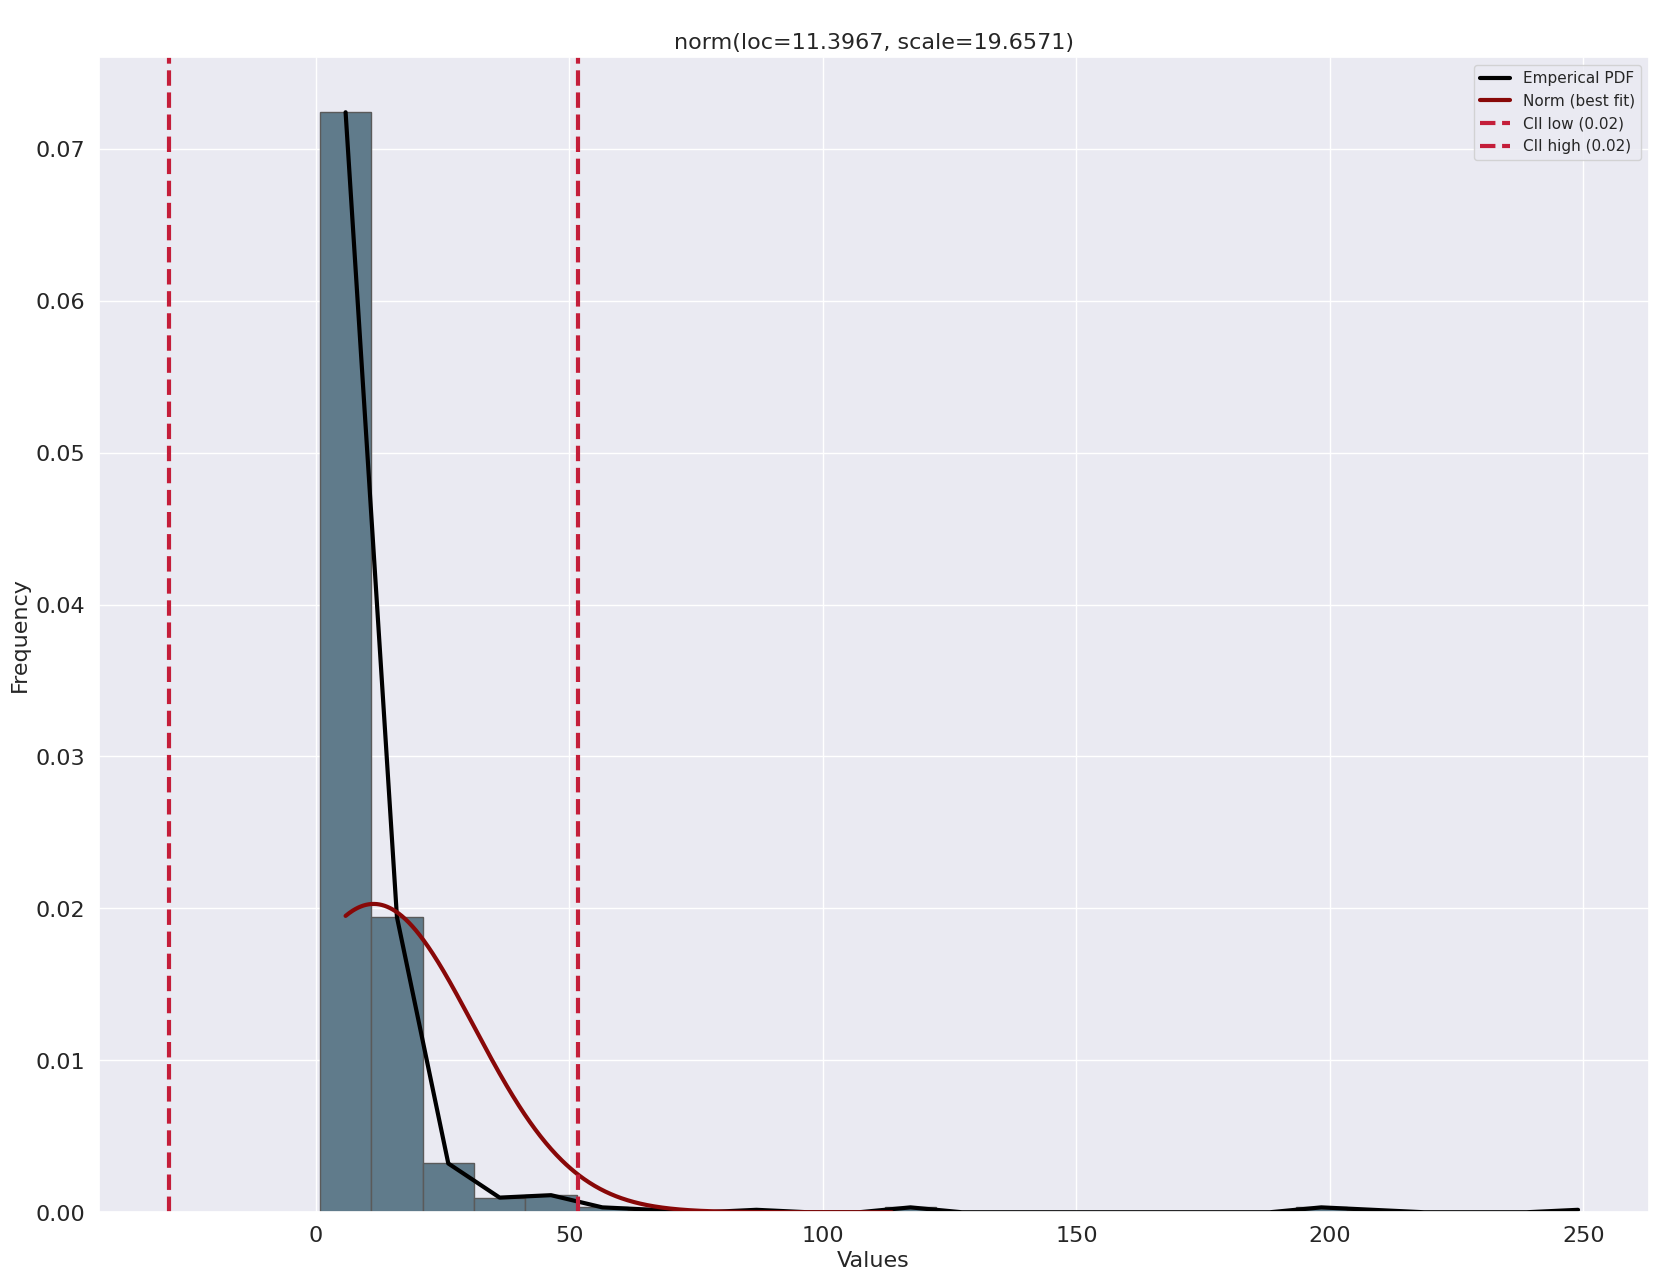

In [18]:
# Plotting the distribution of BIL
BIL = distfit(bins=25, alpha = 0.02, stats = 'ks')
BIL.fit_transform(df['BIL'], verbose = 1)
BIL.summary

BIL.plot(verbose=1)

As per the Metrics in the above table the given disttibution is likely to be Normal Distribution

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >DEBUG> (8.196634146341465, 2.203863323592897)
[distfit] >INFO> [norm      ] [0.00 sec] [ks: 0.0385821] [loc=8.197 scale=2.204]
[distfit] >DEBUG> (1.42, 6.776634146341465)
[distfit] >INFO> [expon     ] [0.00 sec] [ks: 1.44841] [loc=1.420 scale=6.777]
[distfit] >DEBUG> (79223830.85033594, -536870910.58, 536870911.99999994)
[distfit] >INFO> [pareto    ] [0.00 sec] [ks: 1.44841] [loc=-536870910.580 scale=536870912.000]
[distfit] >DEBUG> (1.1833849407601034, 8.243293217317866, 1.7728495544415512)
[distfit] >INFO> [dweibull  ] [0.04 sec] [ks: 1.15279e-07] [loc=8.243 scale=1.773]
[distfit] >DEBUG> (5.876232538959293, 8.23226335746508, 1.8056697291845927)
[distfit] >INFO> [t         ] [0.42 sec] [ks: 1.15279e-07] [loc=8.232 scale=1.806]
[distfit] >DEBUG> (0.22937374917153536, 7.357497156475636, 2.27285851966929)
[distfit] >INFO> [genextreme] [0.39 sec] [ks: 0.0385821] [loc=7.357 scale=2.273]
[distfit] >DEBUG> (738.6272002422975, -51.91

(<Figure size 2000x1500 with 1 Axes>,
 <Axes: title={'center': '\ndweibull(c=1.18338, loc=8.24329, scale=1.77285)'}, xlabel='Values', ylabel='Frequency'>)

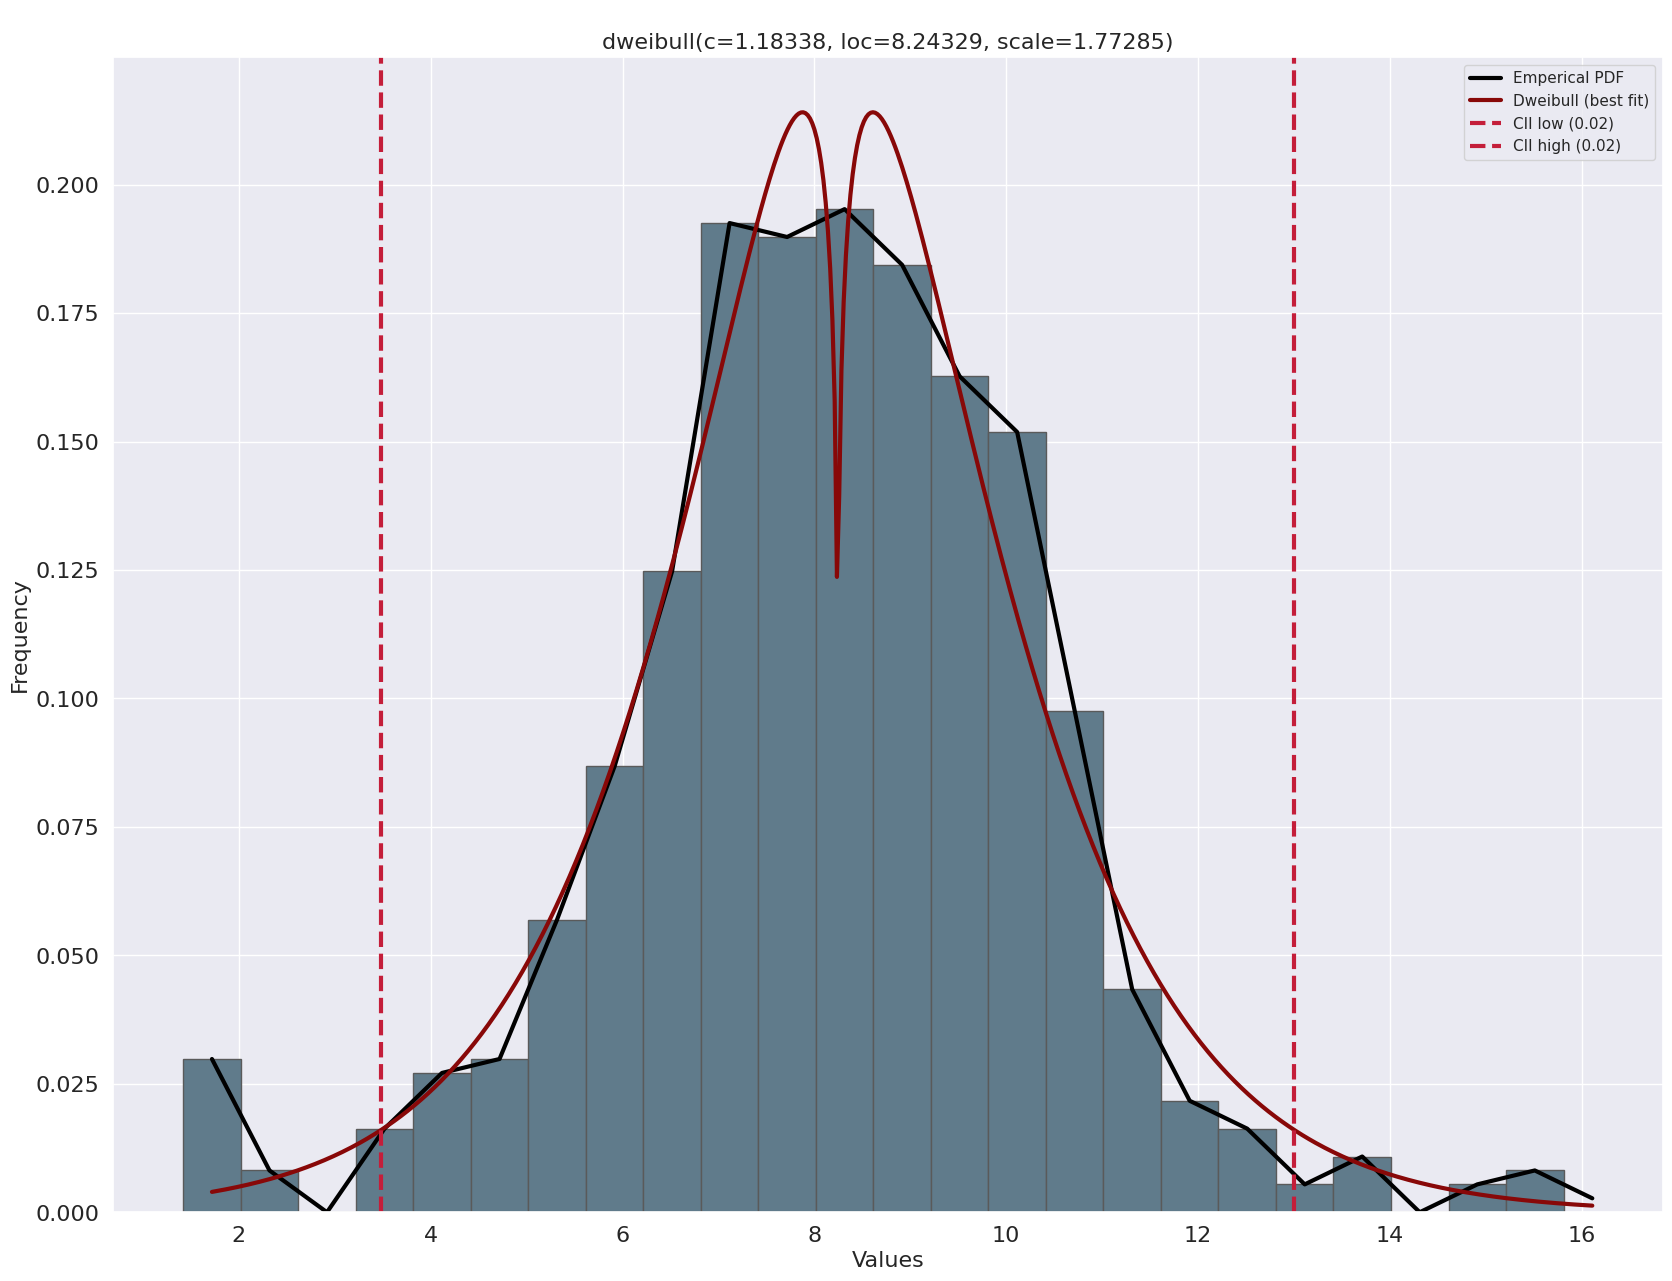

In [19]:
# Plotting the distribution of CHE
CHE = distfit(bins=25, alpha = 0.02, stats = 'ks')
CHE.fit_transform(df['CHE'], verbose = 1)
CHE.summary

CHE.plot(verbose=1)

As per the Metrics in the above table the given disttibution is likely to be Dweibull Distribution

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >DEBUG> (5.368099173553719, 1.1225526326586024)
[distfit] >INFO> [norm      ] [0.00 sec] [ks: 0.0385821] [loc=5.368 scale=1.123]
[distfit] >DEBUG> (1.43, 3.938099173553719)
[distfit] >INFO> [expon     ] [0.00 sec] [ks: 1.82862] [loc=1.430 scale=3.938]
[distfit] >DEBUG> (68163712.15615702, -268435454.57, 268435455.99999997)
[distfit] >INFO> [pareto    ] [0.00 sec] [ks: 1.82862] [loc=-268435454.570 scale=268435456.000]
[distfit] >DEBUG> (1.2015210743403395, 5.275575187730635, 0.9275489225925412)
[distfit] >INFO> [dweibull  ] [0.01 sec] [ks: 0.00194497] [loc=5.276 scale=0.928]
[distfit] >DEBUG> (11.181614097329636, 5.341872179198606, 1.0174291417268404)
[distfit] >INFO> [t         ] [0.26 sec] [ks: 0.00194497] [loc=5.342 scale=1.017]
[distfit] >DEBUG> (0.17364193237687203, 4.921452130559562, 1.067380174561014)
[distfit] >INFO> [genextreme] [0.17 sec] [ks: 0.0385821] [loc=4.921 scale=1.067]
[distfit] >DEBUG> (60.767533927934686, -3.

(<Figure size 2000x1500 with 1 Axes>,
 <Axes: title={'center': '\ndweibull(c=1.20152, loc=5.27558, scale=0.927549)'}, xlabel='Values', ylabel='Frequency'>)

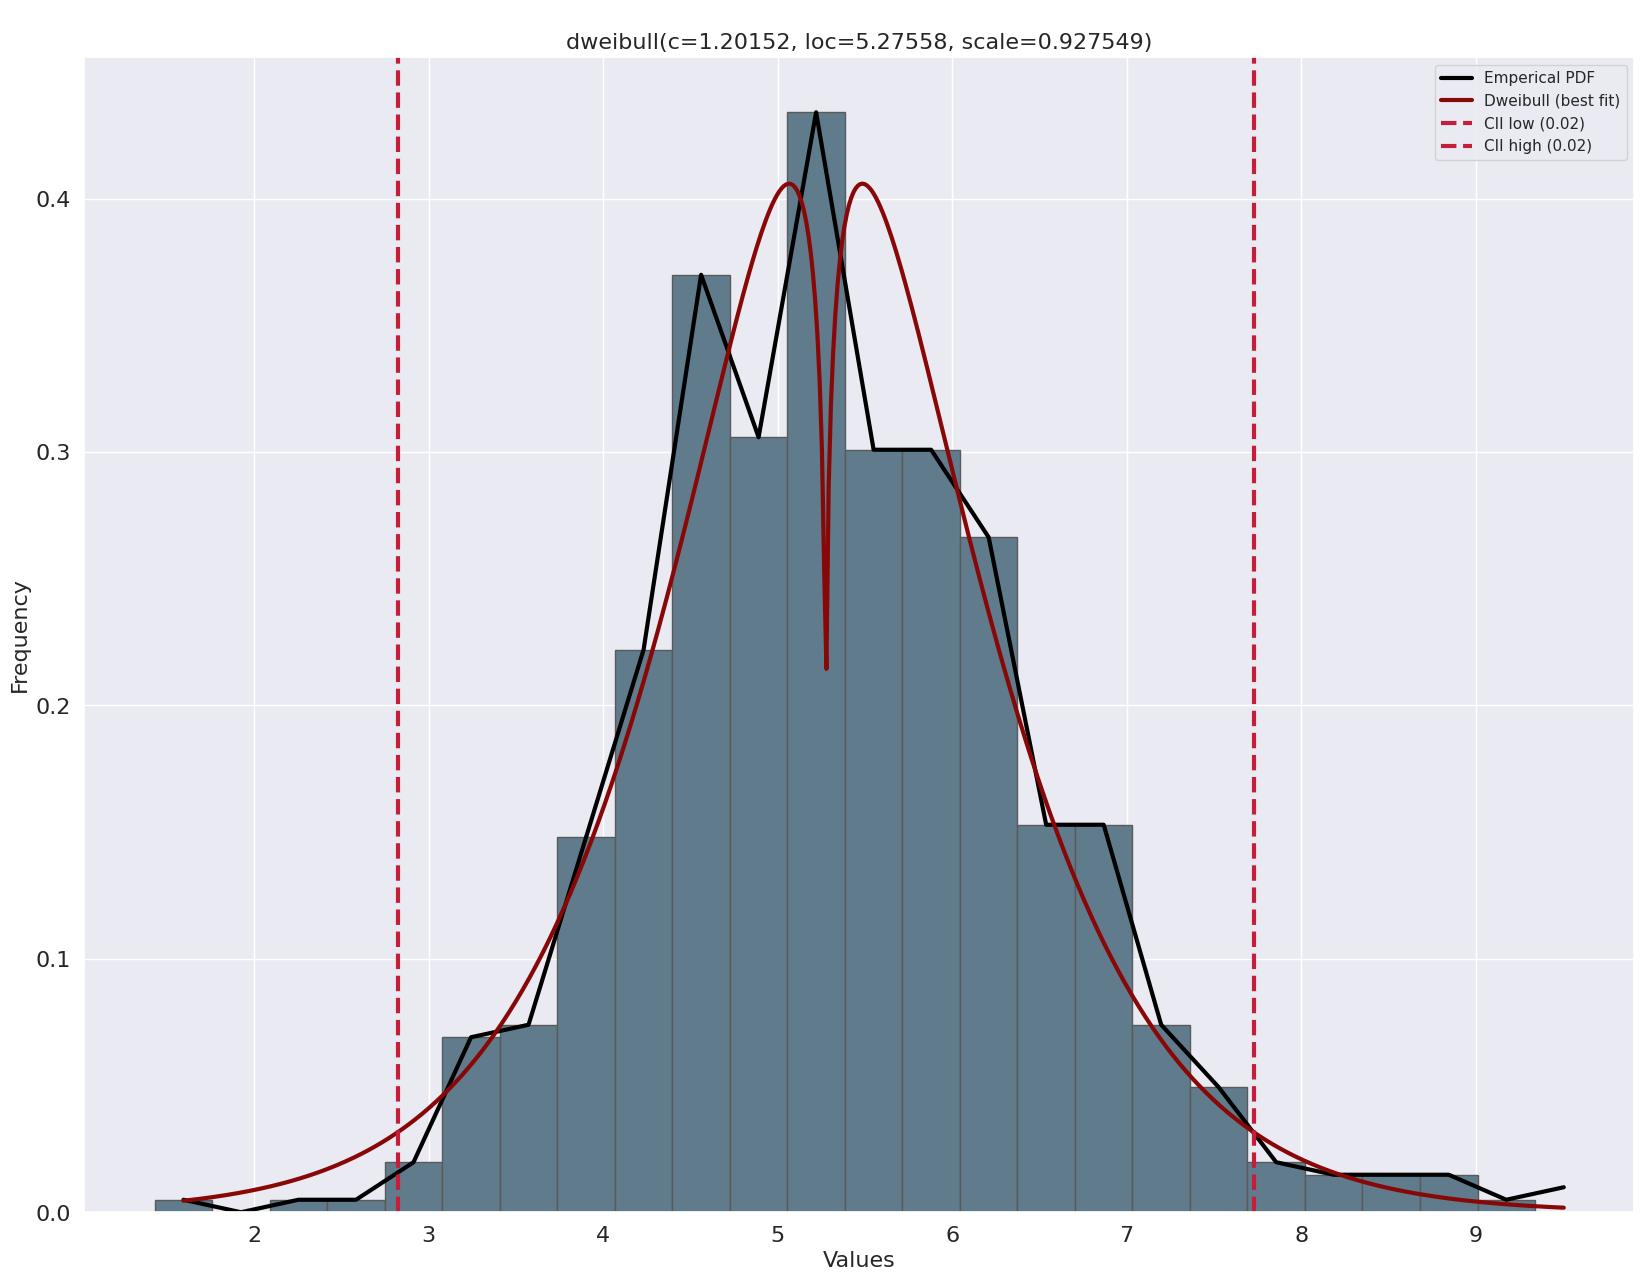

In [20]:
# Plotting the distribution of CHOL
CHOL = distfit(bins=25, alpha = 0.02, stats = 'ks')
CHOL.fit_transform(df['CHOL'], verbose = 1)
CHOL.summary

CHOL.plot(verbose=1)

As per the Metrics in the above table the given disttibution is likely to be Dweibull Distribution

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >DEBUG> (81.28780487804877, 49.71569738750685)
[distfit] >INFO> [norm      ] [0.00 sec] [ks: 6.59961] [loc=81.288 scale=49.716]
[distfit] >DEBUG> (8.0, 73.28780487804877)
[distfit] >INFO> [expon     ] [0.00 sec] [ks: 6.59961] [loc=8.000 scale=73.288]
[distfit] >DEBUG> (117208240.30410273, -8589934584.0, 8589934591.999999)
[distfit] >INFO> [pareto    ] [0.00 sec] [ks: 6.59961] [loc=-8589934584.000 scale=8589934592.000]
[distfit] >DEBUG> (0.8623419780920762, 75.99999999999999, 14.533081986572743)
[distfit] >INFO> [dweibull  ] [0.14 sec] [ks: 6.59961] [loc=76.000 scale=14.533]
[distfit] >DEBUG> (3.373183787835051, 77.24378255766875, 12.446582264450957)
[distfit] >INFO> [t         ] [0.35 sec] [ks: 6.59961] [loc=77.244 scale=12.447]
[distfit] >DEBUG> (-2.2077554904267593, 12.801801401073309, 10.819986743594633)
[distfit] >INFO> [genextreme] [0.30 sec] [ks: 6.59961] [loc=12.802 scale=10.820]
[distfit] >DEBUG> (0.0018117610783666455, 

(<Figure size 2000x1500 with 1 Axes>,
 <Axes: title={'center': '\nnorm(loc=81.2878, scale=49.7157)'}, xlabel='Values', ylabel='Frequency'>)

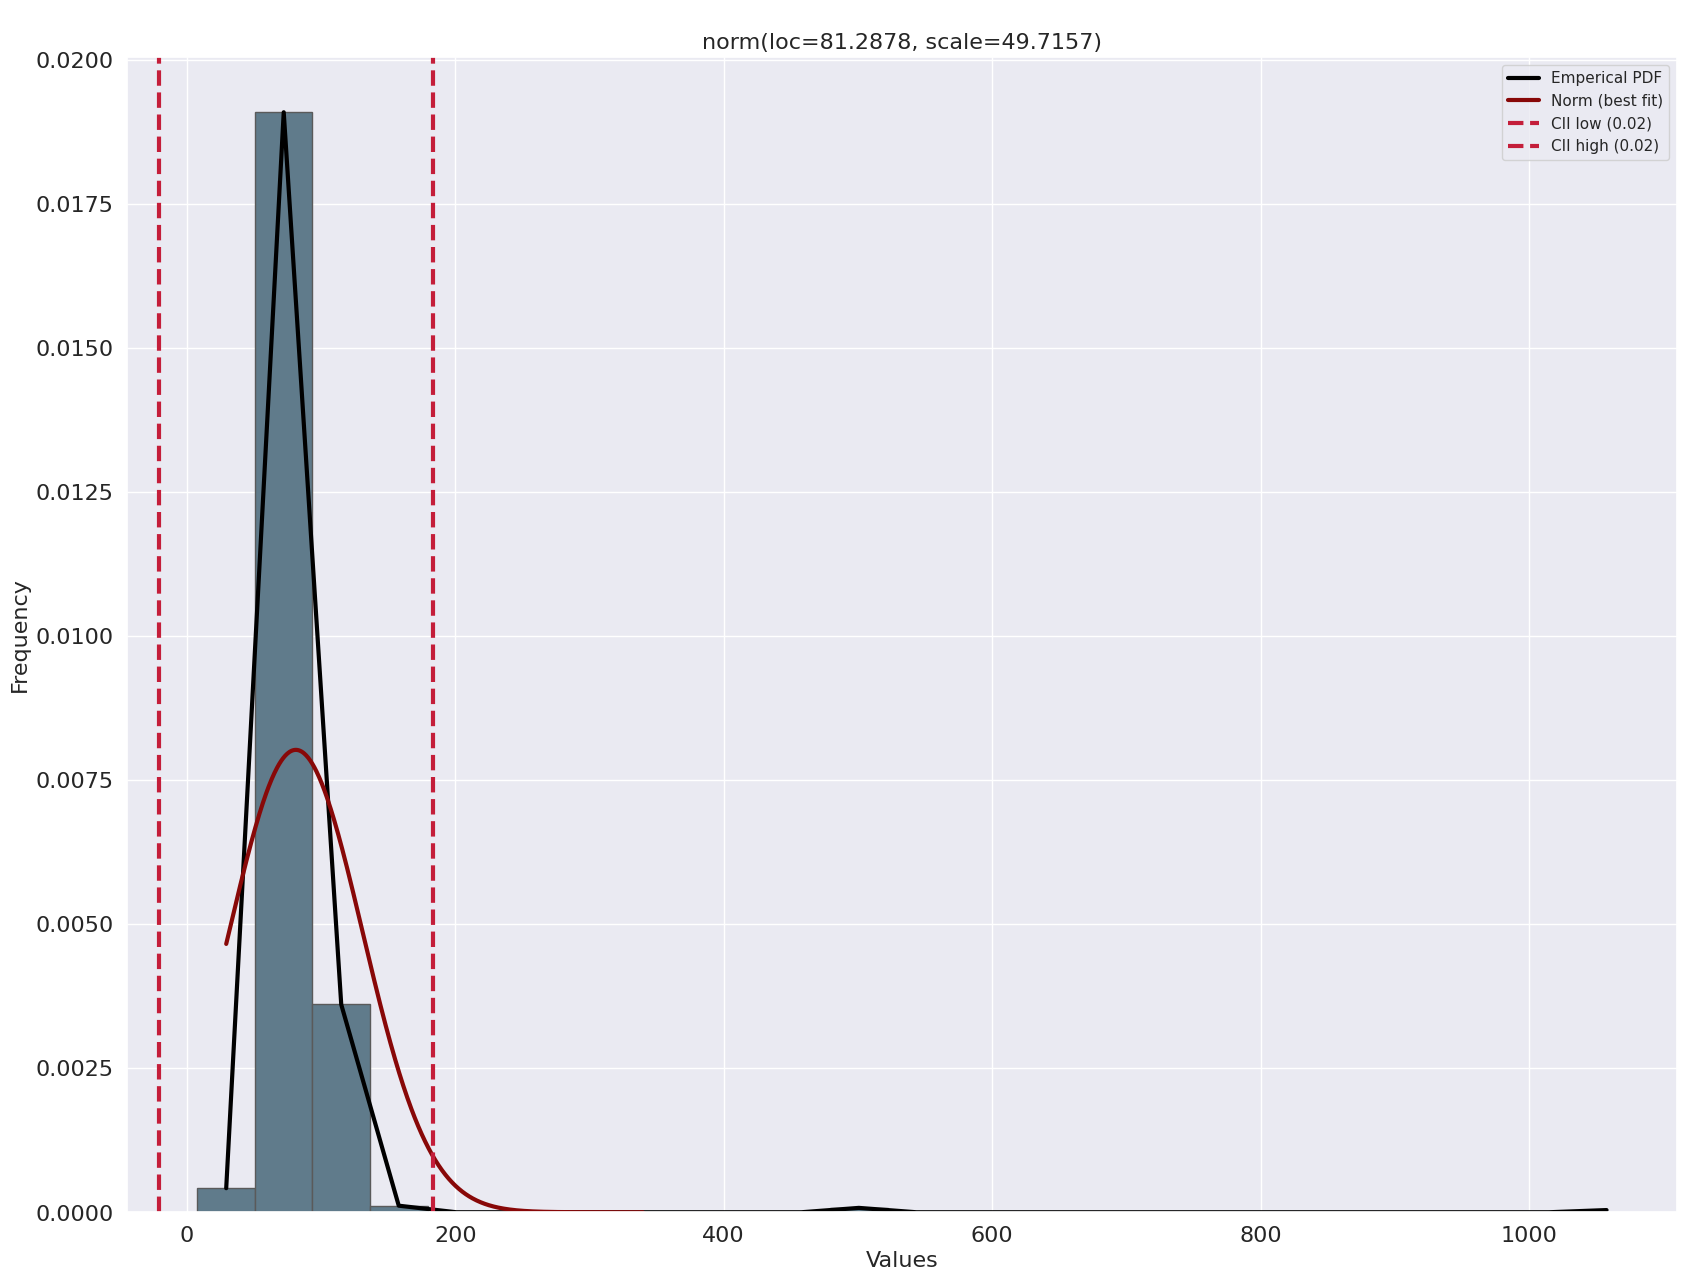

In [21]:
# Plotting the distribution of CREA
CREA = distfit(bins=25, alpha = 0.02, stats = 'ks')
CREA.fit_transform(df['CREA'], verbose = 1)
CREA.summary

CREA.plot(verbose=1)

As per the Metrics in the above table the given disttibution is likely to be Normal Distribution

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >DEBUG> (39.53317073170732, 54.61661326389623)
[distfit] >INFO> [norm      ] [0.00 sec] [ks: 1.10847] [loc=39.533 scale=54.617]
[distfit] >DEBUG> (4.5, 35.03317073170732)
[distfit] >INFO> [expon     ] [0.00 sec] [ks: 1.10847] [loc=4.500 scale=35.033]
[distfit] >DEBUG> (4.631917495905958, -119.97904424521082, 124.4790442452108)
[distfit] >INFO> [pareto    ] [0.00 sec] [ks: 0.807543] [loc=-119.979 scale=124.479]
[distfit] >DEBUG> (0.6926364967187456, 19.099999999999998, 29.503294061608543)
[distfit] >INFO> [dweibull  ] [0.06 sec] [ks: 0.807543] [loc=19.100 scale=29.503]
[distfit] >DEBUG> (1.072429208181784, 20.820601591911604, 8.65122536500483)
[distfit] >INFO> [t         ] [0.10 sec] [ks: 1.10847] [loc=20.821 scale=8.651]
[distfit] >DEBUG> (-0.5687007696601278, 19.281334159212726, 11.71884761377446)
[distfit] >INFO> [genextreme] [0.16 sec] [ks: 0.807543] [loc=19.281 scale=11.719]
[distfit] >DEBUG> (0.023850000227517397, 4.4999999

(<Figure size 2000x1500 with 1 Axes>,
 <Axes: title={'center': '\npareto(b=4.63192, loc=-119.979, scale=124.479)'}, xlabel='Values', ylabel='Frequency'>)

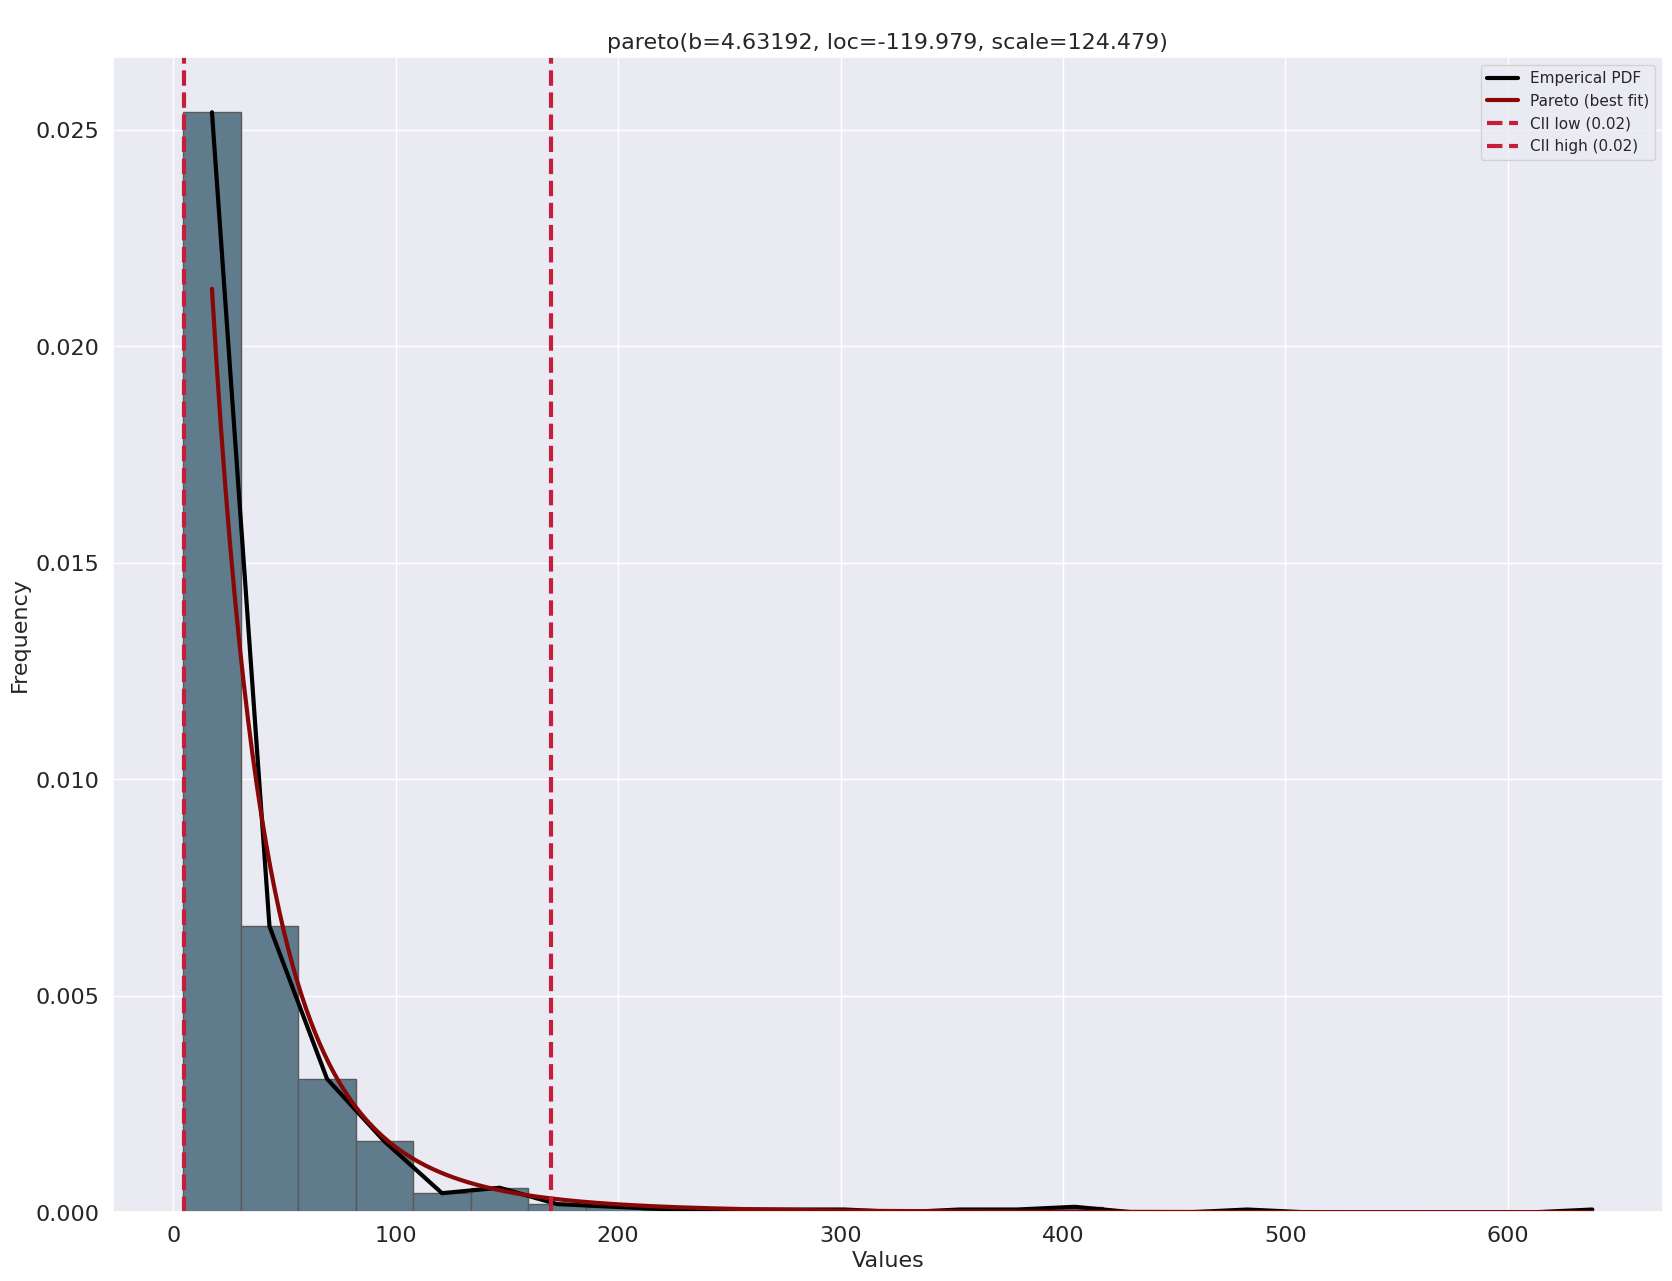

In [23]:
# Plotting the distribution of GGT
GGT = distfit(bins=25, alpha = 0.02, stats = 'ks')
GGT.fit_transform(df['GGT'], verbose = 1)
GGT.summary

GGT.plot(verbose=1)

As per the Metrics in the above table the given disttibution is likely to be Dweibull Distribution

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >DEBUG> (72.0441368078176, 5.3938438098195505)
[distfit] >INFO> [norm      ] [0.00 sec] [ks: 0.322892] [loc=72.044 scale=5.394]
[distfit] >DEBUG> (44.8, 27.244136807817597)
[distfit] >INFO> [expon     ] [0.00 sec] [ks: 3.22842] [loc=44.800 scale=27.244]
[distfit] >DEBUG> (78823699.86707172, -2147483603.2, 2147483648.0)
[distfit] >INFO> [pareto    ] [0.00 sec] [ks: 3.22842] [loc=-2147483603.200 scale=2147483648.000]
[distfit] >DEBUG> (1.068214721982572, 72.15689753160588, 3.9886703284594276)
[distfit] >INFO> [dweibull  ] [0.01 sec] [ks: 0.0385821] [loc=72.157 scale=3.989]
[distfit] >DEBUG> (10.541463049832501, 72.04055787581208, 5.37506069078904)
[distfit] >INFO> [t         ] [0.27 sec] [ks: 0.0385821] [loc=72.041 scale=5.375]
[distfit] >DEBUG> (2.9466752544171095, 88.62436285260063, 4.0535559412986775)
[distfit] >INFO> [genextreme] [0.37 sec] [ks: 0.545091] [loc=88.624 scale=4.054]
[distfit] >DEBUG> (384.45622563709696, -36.2008

(<Figure size 2000x1500 with 1 Axes>,
 <Axes: title={'center': '\ndweibull(c=1.06821, loc=72.1569, scale=3.98867)'}, xlabel='Values', ylabel='Frequency'>)

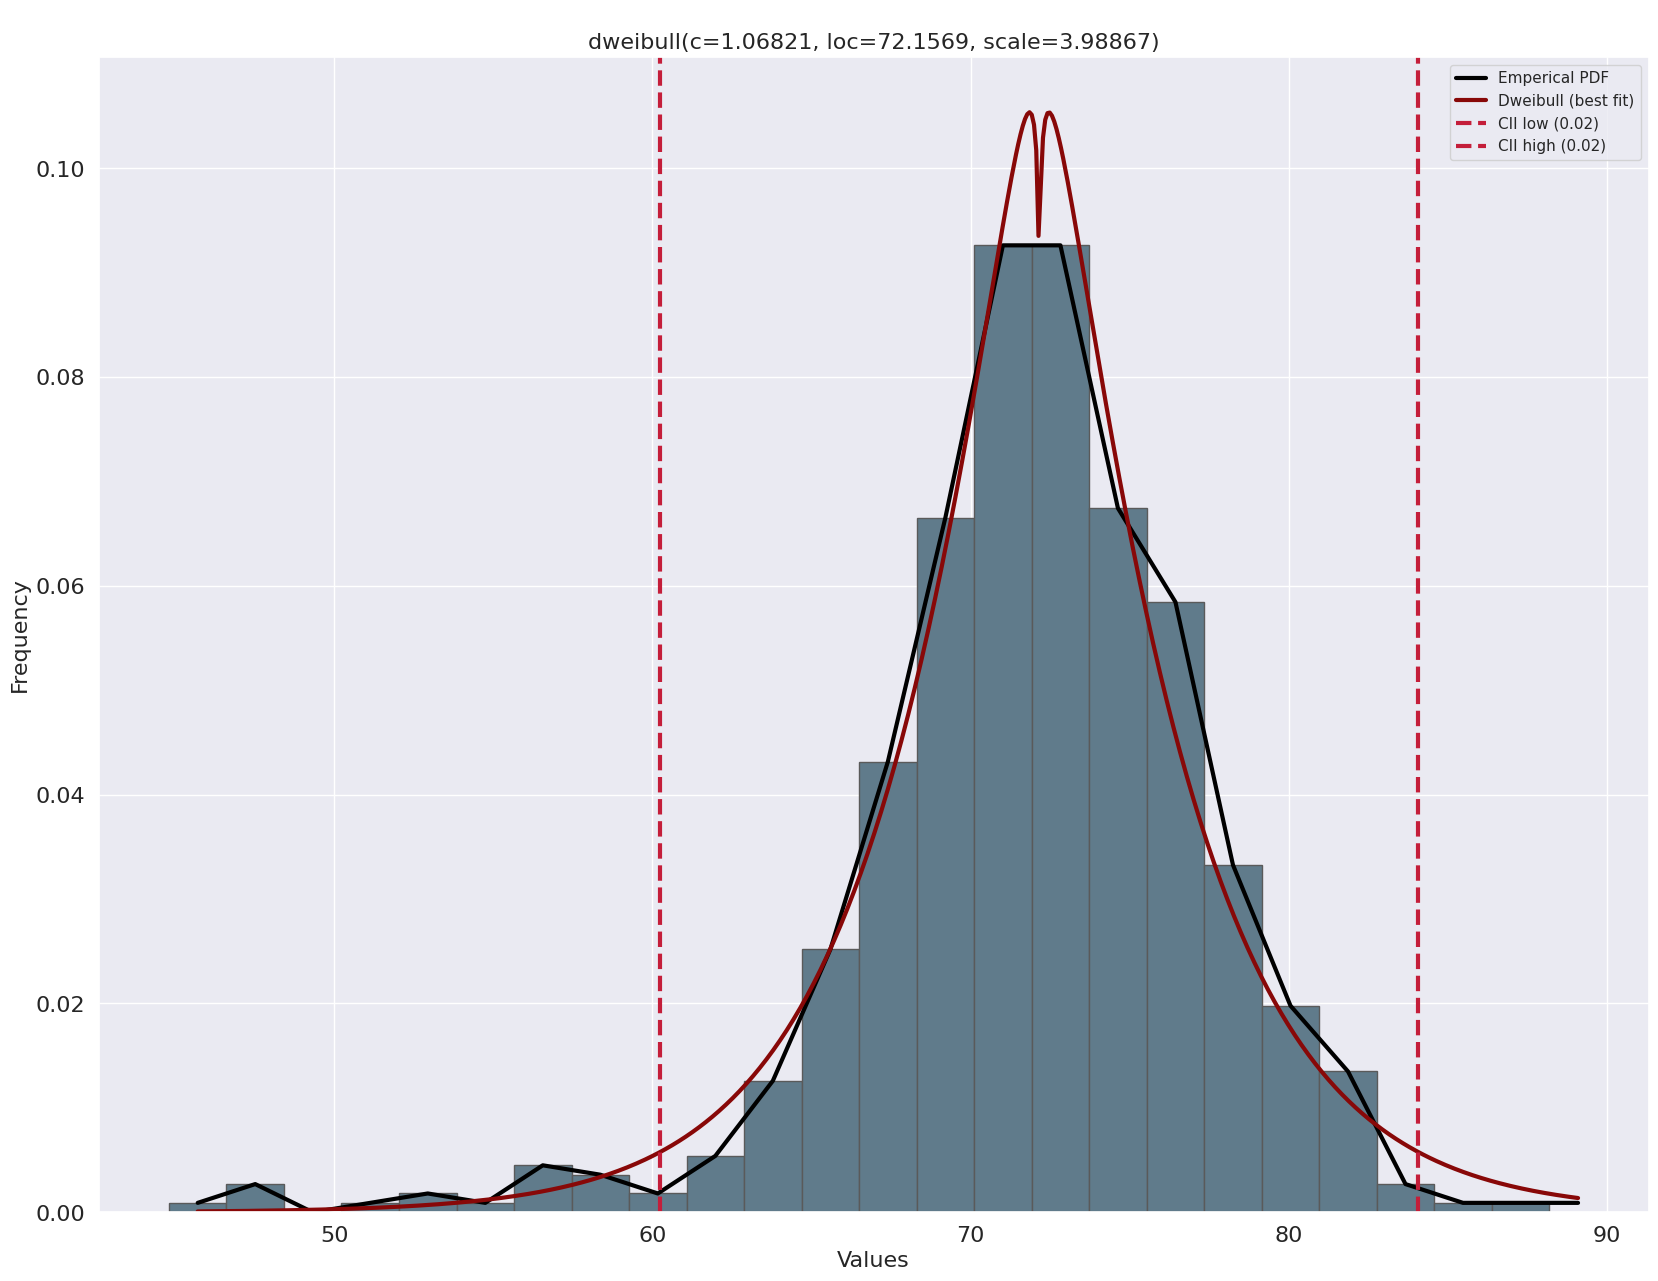

In [24]:
# Plotting the distribution of PROT
PROT = distfit(bins=25, alpha = 0.02, stats = 'ks')
PROT.fit_transform(df['PROT'], verbose = 1)
PROT.summary

PROT.plot(verbose=1)

<Axes: title={'center': 'Category'}>

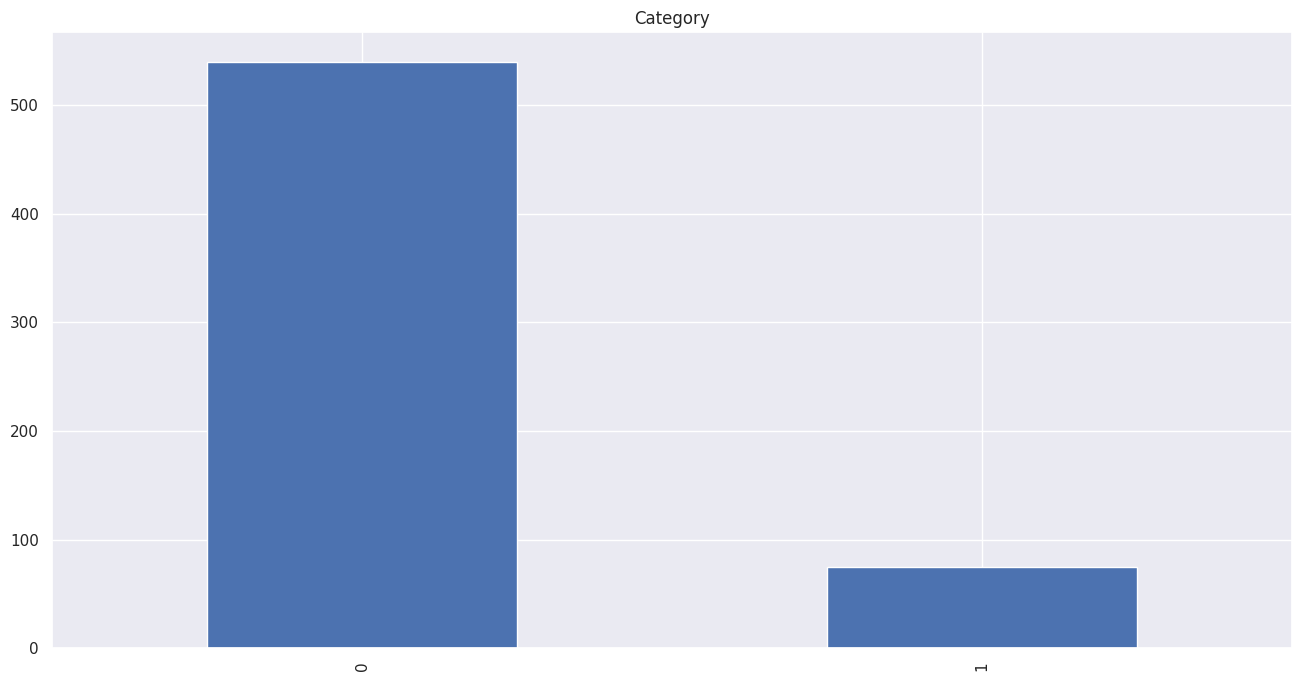

In [25]:
# Distribution of Caregorical Data
plt.title("Category")
df["Category"].value_counts().plot(kind="bar")

<Axes: title={'center': 'Sex'}>

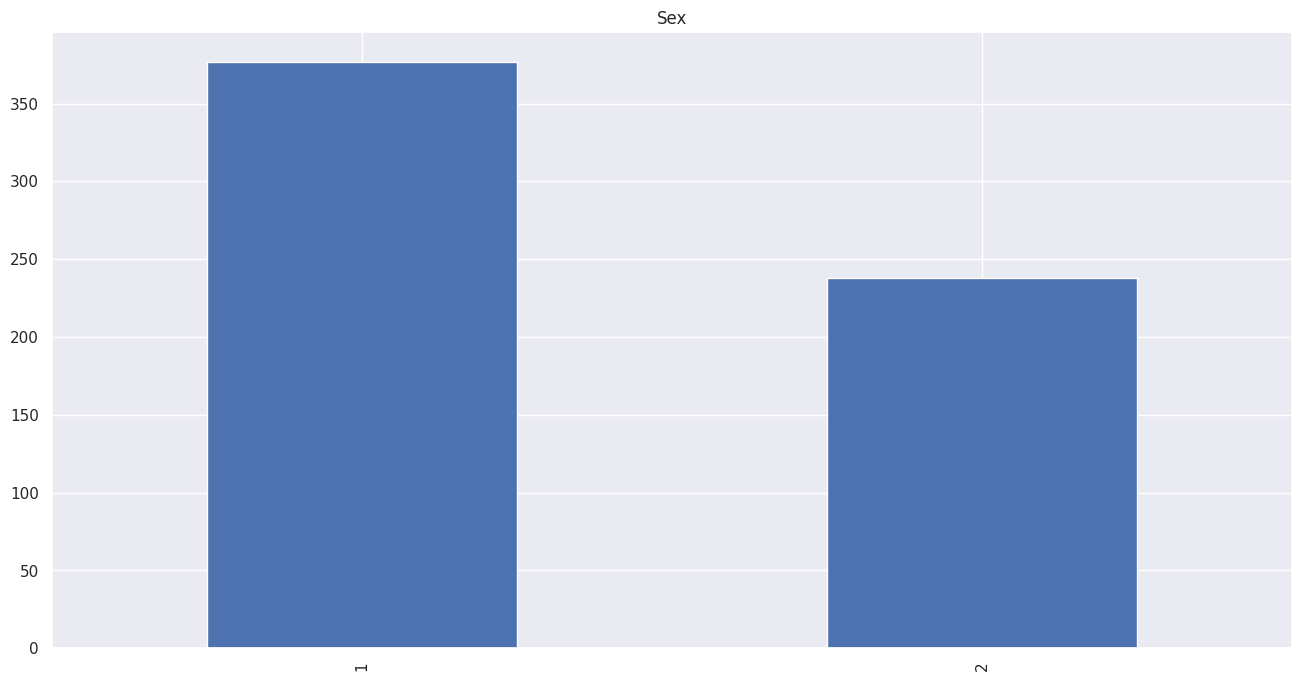

In [26]:
# Distribution of Caregorical Data
plt.title("Sex")
df["Sex"].value_counts().plot(kind="bar")

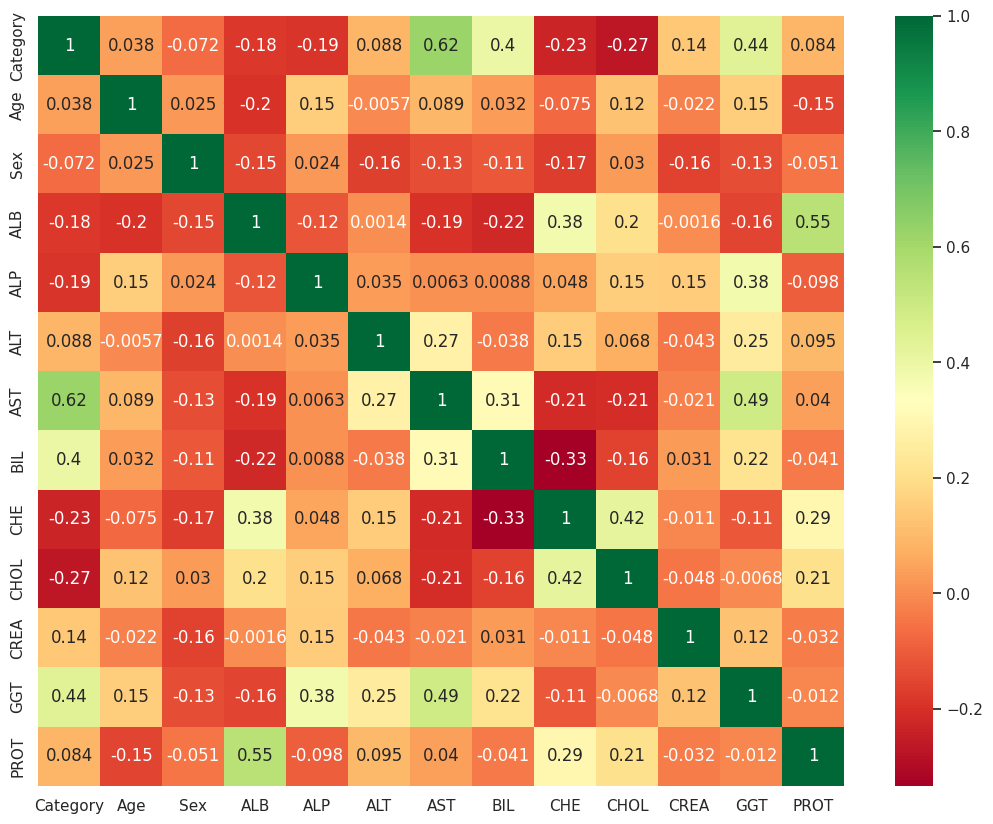

In [27]:
# Having a look at the correlation matrix

fig, ax = plt.subplots(figsize=(13,10))
sns.heatmap(df.corr(), annot=True, cmap="RdYlGn");

In [29]:
# Dropping Category and Checking VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
X=df.drop(["Category"], axis=1)
vif = pd.DataFrame()
vif["features"] = X.columns
vif["vif_Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

   features  vif_Factor
0       Age   21.775130
1       Sex   10.090546
2       ALB   90.366896
3       ALP    9.222964
4       ALT    2.683906
5       AST    3.474657
6       BIL    1.690610
7       CHE   23.527361
8      CHOL   32.394743
9      CREA    3.847445
10      GGT    2.585270
11     PROT  158.297083


In [30]:
# Dropping PROT and Checking VIF
df=df.drop(["PROT"], axis=1)
vif = pd.DataFrame()
vif["features"] = df.columns
vif["vif_Factor"] = [variance_inflation_factor(df.values, i) for i in range(X.shape[1])]
print(vif)

    features  vif_Factor
0   Category    2.665531
1        Age   20.208865
2        Sex    8.924980
3        ALB   35.851500
4        ALP   10.986868
5        ALT    2.681773
6        AST    4.160271
7        BIL    1.726406
8        CHE   22.854858
9       CHOL   31.870357
10      CREA    4.004209
11       GGT    2.937584


As we see, we have dropped the column "PROT", as it has very high multicollinearity. Om its removal, the VIF has drastically reduced.

## What kind of data exploration did you do?

### Preliminary findings from the EDA.

**Datatype Check** - All the features in the dataset are Integers/ Float.

**Missing Data Check** - Our Dataset had missing values in many of the features, which were above removed by mean/median/mode.

**Distribution of training data** - I checked the probability distribution of each and every feature in the training dataset

**Correlation Check**- I performed a correlation check on the dataset using heatmap and pirplot, the findings from it was that the didn't had any significant multi colinearity issues.

**Barplot**- Performed Barplot analysis to findout the distribution of the categorical features.

The above graphs are a cohesive representation of the presence of Hepatitis C w.r.t. all the significant variables.

A few findings which we can interpret from the above graph as

*   Presence of Hepatitis C is positively correlated with AST
*   Presence of Hepatitis C is positively correlated with GGT

These are the preliminary findings about how the individual parameters.

### Data Cleaning

This dataset was relatively cleaner with some missing values. But handing missing values is one of the most important tasks in any Data Science project.

###vHandling Missing Data

In any ML modeling task, one of the very important task is to check if we have any missing values in our dataset. If there are missing values in the dataset it can horribly change the results and make our model inefficient.

But there are ways to tackle this problem, we will discuss these methods in a bit detail below

### How to handle missing data - Data Imputation techniques

* Delete rows with missing data
* Fill the missing data points by either mean/mode/median
* Model a regression with rest of the feature as input and the missing value as the target i.e. MICE Imputation

Our dataset have any missing values which has been handled by mean/median/mode.

## Data Imputation Study

Lets deliberately create some missing values and have a comparative analysis of how effectively each method is recovering the data back.

We will remove 1%, 5% and 10% of the data from alcohol in our dataset and see how well Mean Imputation and MICE imputation will recover the data back

In [32]:
# Creating the new dataset
df_impute = df[~df["AST"].isnull()]
df_impute

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT
0,0,32,1,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1
1,0,32,1,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6
2,0,32,1,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2
3,0,32,1,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8
4,0,32,1,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9
...,...,...,...,...,...,...,...,...,...,...,...,...
610,1,62,2,32.0,416.6,5.9,110.3,50.0,5.57,6.30,55.7,650.9
611,1,64,2,24.0,102.8,2.9,44.4,20.0,1.54,3.02,63.0,35.9
612,1,64,2,29.0,87.3,3.5,99.0,48.0,1.66,3.63,66.7,64.2
613,1,46,2,33.0,23.0,39.0,62.0,20.0,3.56,4.20,52.0,50.0


In [33]:
# Checking for nulls
df_impute.isnull().sum()

Category    0
Age         0
Sex         0
ALB         0
ALP         0
ALT         0
AST         0
BIL         0
CHE         0
CHOL        0
CREA        0
GGT         0
dtype: int64

In [35]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Standardizing the new dataset
df_impute = scaler.fit_transform(df_impute)
df_impute = pd.DataFrame(df_impute, columns = ['Category', 'Age', 'Sex', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE','CHOL', 'CREA', 'GGT'])
df_impute

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT
0,-0.372678,-1.533616,-0.794544,-0.540647,-0.540792,-0.815675,-0.383693,-0.198236,-0.574734,-1.904676,0.497070,-0.502286
1,-0.372678,-1.533616,-0.794544,-0.540647,0.124981,-0.410629,-0.305057,-0.381375,1.349161,-0.506078,-0.146590,-0.438203
2,-0.372678,-1.533616,-0.794544,0.914850,0.289554,0.305084,0.538767,-0.269457,0.291926,-0.149747,0.094783,-0.115957
3,-0.372678,-1.533616,-0.794544,0.273738,-0.559494,0.084865,-0.368571,0.381706,-0.393234,-0.559528,-0.025903,-0.104971
4,-0.372678,-1.533616,-0.794544,-0.419356,0.267112,0.163515,-0.302033,-0.091404,0.432588,-0.933675,-0.106361,-0.176378
...,...,...,...,...,...,...,...,...,...,...,...,...
610,2.683282,1.452371,1.258584,-1.666925,13.077633,-0.886460,2.283879,1.963828,-1.191832,0.830162,-0.514683,11.193789
611,2.683282,1.651437,1.258584,-3.053113,1.340578,-1.004434,0.290761,0.437665,-3.020439,-2.091750,-0.367848,-0.066521
612,2.683282,1.651437,1.258584,-2.186746,0.760831,-0.980839,1.942115,1.862083,-2.965989,-1.548345,-0.293425,0.451636
613,2.683282,-0.140155,1.258584,-1.493652,-1.644180,0.415194,0.823066,0.437665,-2.103866,-1.040574,-0.589106,0.191642


In [36]:
# Creating three extra coloumns of AST for performing Data Imputation techniques
df_impute["AST_1_percent"] = df_impute[["AST"]]
df_impute["AST_5_percent"] = df_impute[["AST"]]
df_impute["AST_10_percent"] = df_impute[["AST"]]

In [37]:
# Function to calculate percentage of missing data in dataset
def get_percent_missing(dataframe):

    percent_missing = dataframe.isnull().sum() * 100 / len(dataframe)
    missing_value_df = pd.DataFrame(
        {"column_name": dataframe.columns, "percent_missing": percent_missing}
    )
    return missing_value_df

# Function to create missing values
def create_missing(dataframe, percent, col):
    dataframe.loc[dataframe.sample(frac=percent).index, col] = np.nan

# Function to calculate how well the data has been recovered after performing data imputation
def percentage_change(l1, l2):
    percent_change = abs((l1 - l2) / (l1+ 0.000000001))
    avg_change = (percent_change.sum() / percent_change.count()) * 100
    return avg_change
     

In [38]:
# Cross checking for nulls
print(get_percent_missing(df_impute))

                   column_name  percent_missing
Category              Category              0.0
Age                        Age              0.0
Sex                        Sex              0.0
ALB                        ALB              0.0
ALP                        ALP              0.0
ALT                        ALT              0.0
AST                        AST              0.0
BIL                        BIL              0.0
CHE                        CHE              0.0
CHOL                      CHOL              0.0
CREA                      CREA              0.0
GGT                        GGT              0.0
AST_1_percent    AST_1_percent              0.0
AST_5_percent    AST_5_percent              0.0
AST_10_percent  AST_10_percent              0.0


In [39]:
# Creating missing values in respected coloumns to perform data imputation
create_missing(df_impute, 0.01, "AST_1_percent")
create_missing(df_impute, 0.05, "AST_5_percent")
create_missing(df_impute, 0.1, "AST_10_percent")

In [40]:
# Double Checking the imputation operation
print(get_percent_missing(df_impute))

                   column_name  percent_missing
Category              Category         0.000000
Age                        Age         0.000000
Sex                        Sex         0.000000
ALB                        ALB         0.000000
ALP                        ALP         0.000000
ALT                        ALT         0.000000
AST                        AST         0.000000
BIL                        BIL         0.000000
CHE                        CHE         0.000000
CHOL                      CHOL         0.000000
CREA                      CREA         0.000000
GGT                        GGT         0.000000
AST_1_percent    AST_1_percent         0.975610
AST_5_percent    AST_5_percent         5.040650
AST_10_percent  AST_10_percent        10.081301


In [41]:
# Function to impute data using MICE method
def mice_impute(df_impute):
    mice_imputed_train_df = pd.DataFrame(
        MICE().fit_transform(df_impute), columns=list(df_impute.columns)
    )
    return mice_imputed_train_df
     

In [42]:
# Dataframe for 1% missing value
train_df_selected_1_percent = df_impute.drop(
    ["AST", "AST_5_percent", "AST_10_percent"], axis=1
)
# Dataframe for 5% missing value
train_df_selected_5_percent = df_impute.drop(
    ["AST", "AST_1_percent", "AST_10_percent"], axis=1
)
# Dataframe for 10% missing value
train_df_selected_10_percent = df_impute.drop(
    ["AST", "AST_1_percent", "AST_5_percent"], axis=1
)

# Performing Imputation on Dataframe with 1% missing values
imputed_train_df_selected_1_percent = mice_impute(train_df_selected_1_percent)
# Performing Imputation on Dataframe with 5% missing values
imputed_train_df_selected_5_percent = mice_impute(train_df_selected_5_percent)
# Performing Imputation on Dataframe with 10% missing values
imputed_train_df_selected_10_percent = mice_impute(train_df_selected_10_percent)

In [43]:
# This is the average % error on residuals for 1% missing data imputed using MICE Imputation
print("Average % error on residuals for 1% missing data imputed using MICE Imputation")
print(
    percentage_change(
        df_impute["AST"],
        imputed_train_df_selected_1_percent["AST_1_percent"]
    )
)

Average % error on residuals for 1% missing data imputed using MICE Imputation
0.5822466750174691


In [44]:
# This is the average % error on residuals for 5% missing data imputed using MICE Imputation
print("Average % error on residuals for 5% missing data imputed using MICE Imputation")
print(
    percentage_change(
        df_impute["AST"],
        imputed_train_df_selected_5_percent["AST_5_percent"]
    )
)

Average % error on residuals for 5% missing data imputed using MICE Imputation
5.977156704768359


In [45]:
# This is the average % error on residuals for 10% missing data imputed using MICE Imputation
print("Average % error on residuals for 10% missing data imputed using MICE Imputation")
print(
    percentage_change(
        df_impute["AST"],
        imputed_train_df_selected_10_percent["AST_10_percent"]
    )
)

Average % error on residuals for 10% missing data imputed using MICE Imputation
19.83780821164845


In [46]:
# Performing Mean Imputation
# Modified function to impute data using mean imputation
def mean_impute(train_df):
    mm_impute_train_df = df_impute.copy()  # Make a copy of dataframe for imputation
    mm_impute_train_df["AST_1_percent"] = mm_impute_train_df[
        "AST_1_percent"
    ].fillna(mm_impute_train_df["AST"].mean())
    mm_impute_train_df["AST_5_percent"] = mm_impute_train_df[
        "AST_5_percent"
    ].fillna(mm_impute_train_df["AST"].mean())
    mm_impute_train_df["AST_10_percent"] = mm_impute_train_df[
        "AST_10_percent"
    ].fillna(mm_impute_train_df["AST"].mean())
    return mm_impute_train_df

mm_imputed_train_df = mean_impute(df_impute)

In [47]:
print(get_percent_missing(mm_imputed_train_df))

                   column_name  percent_missing
Category              Category              0.0
Age                        Age              0.0
Sex                        Sex              0.0
ALB                        ALB              0.0
ALP                        ALP              0.0
ALT                        ALT              0.0
AST                        AST              0.0
BIL                        BIL              0.0
CHE                        CHE              0.0
CHOL                      CHOL              0.0
CREA                      CREA              0.0
GGT                        GGT              0.0
AST_1_percent    AST_1_percent              0.0
AST_5_percent    AST_5_percent              0.0
AST_10_percent  AST_10_percent              0.0


In [48]:
# This is the average % error on residuals for 1% missing data imputed using Mean Imputation
print("Average % error on residuals for 1% missing data imputed using Mean Imputation")
print(
    percentage_change(
        mm_imputed_train_df["AST"],
        mm_imputed_train_df["AST_1_percent"],
    )
)

Average % error on residuals for 1% missing data imputed using Mean Imputation
0.975609758036002


In [49]:
# This is the average % error on residuals for 5% missing data imputed using Mean Imputation
print("Average % error on residuals for 5% missing data imputed using Mean Imputation")
print(
    percentage_change(
        mm_imputed_train_df["AST"],
        mm_imputed_train_df["AST_5_percent"]
    )
)

Average % error on residuals for 5% missing data imputed using Mean Imputation
5.040650404398356


In [50]:
# This is the average % error on residuals for 10% missing data imputed using Mean Imputation
print("Average % error on residuals for 10% missing data imputed using Mean Imputation")
print(
    percentage_change(
        mm_imputed_train_df["AST"],
        mm_imputed_train_df["AST_10_percent"]
    )
)

Average % error on residuals for 10% missing data imputed using Mean Imputation
10.081300841368666


### Interpreting the Imputation Methods

From the above 6 readings we can conclude that the MICE imputation works well when compared to the Mean imputation method as the imputed value is a function of rest of the features.

We can also observe that the % error of residuals increase as the missing data points increase. From this we can conclude that if we have less missing data in the dataset, more perfectly it is imputed back by the imputation method.

### Why Imputing data is always better than deleting the row ?

For obvious reason - Data Loss. When we delete a row we end up deleting a sample from training data which will do more harm to the model instead of doing any good.

Selecting of imputation method is really a personal choice, although from the above analysis we can come to the conclusion that MICE does a better job in getting the databack, but after creating a model it hardly has any positive effects on the accuracy of model. But it is always a better choice to use MICE as it can give you the closest possible value.

## Checking Predictor Significance

In [54]:
#Using OLS for finding the p value to check the significant features
import statsmodels.api as sm

model = sm.OLS(df['Category'], df[['Age', 'Sex', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE',
       'CHOL', 'CREA', 'GGT']]).fit()

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               Category   R-squared (uncentered):                   0.625
Model:                            OLS   Adj. R-squared (uncentered):              0.618
Method:                 Least Squares   F-statistic:                              91.45
Date:                Mon, 10 Apr 2023   Prob (F-statistic):                   9.06e-121
Time:                        01:51:33   Log-Likelihood:                          75.848
No. Observations:                 615   AIC:                                     -129.7
Df Residuals:                     604   BIC:                                     -81.06
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Age            0.0009      0.001      1.115      0.265      -0.001       0.002
Sex            0.0644      0.017      3.680      0.000       0.030       0.099
ALB            0.0001      0.001      0.092      0.926      -0.002       0.003
ALP           -0.0040      0.000    -10.862      0.000      -0.005      -0.003
ALT           -0.0008      0.000     -2.269      0.024      -0.002      -0.000
AST            0.0043      0.000     13.072      0.000       0.004       0.005
BIL            0.0035      0.000      7.146      0.000       0.003       0.004
CHE            0.0090      0.005      1.837      0.067      -0.001       0.019
CHOL          -0.0280      0.009     -3.148      0.002      -0.045      -0.011
CREA           0.0011      0.000      6.096      0.000       0.001       0.001
GGT            0.0019      0.000      9.167      0.000       0.001       0.002
==============================================================================
Omnibus:                      211.185   Durbin-Watson:                   1.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              966.827
Skew:                           1.491   Prob(JB):                    1.14e-210
Kurtosis:                       8.370   Cond. No.                         293.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Considering P-Value to be significant at 0.05, the variables "Age" and "CHE" are statistically insignificant and "Sex" is the most statistically significant.

## Outlier Removal

<Axes: >

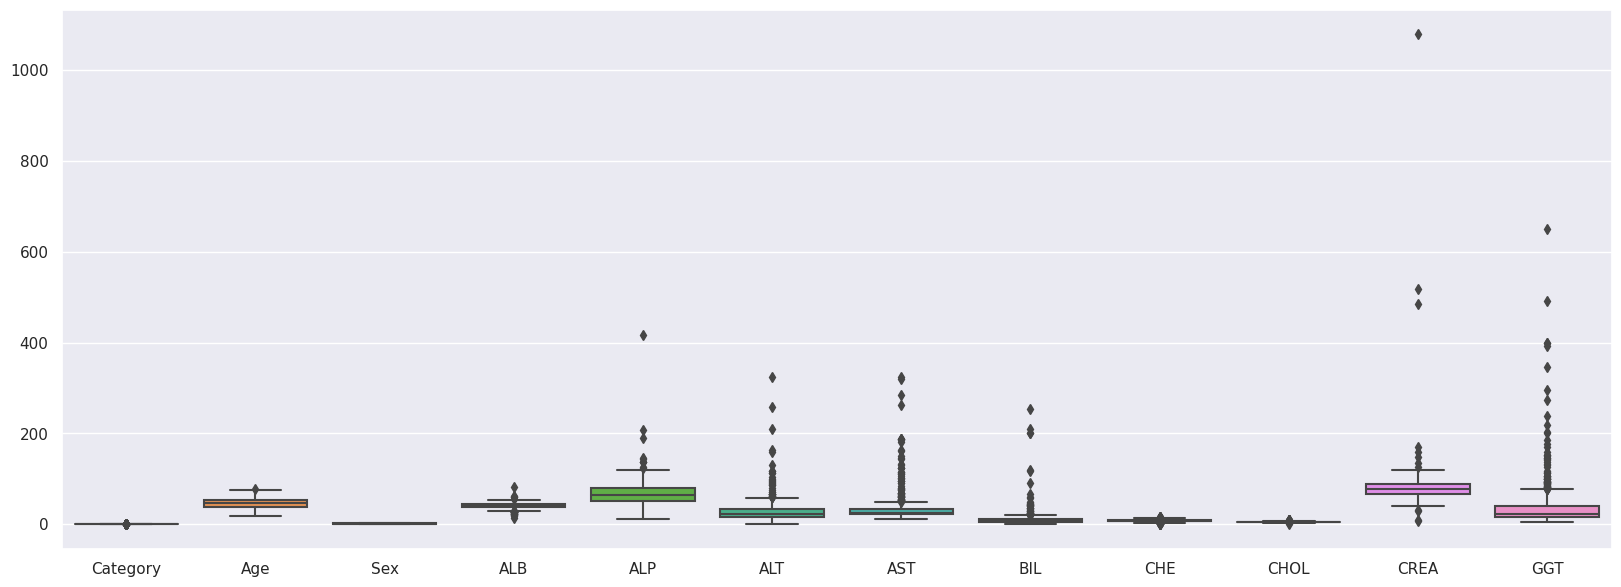

In [55]:
# Plotting a boxplot to check for outliers
plt.figure(figsize=(20,7))
sns.boxplot(data=df)

As we see, most of the variables have a good number of outliers, which needs to be dealt

In [59]:
from tqdm import tqdm
IQR = lambda col : np.percentile(col, 75) - np.percentile(col, 25)

def drop_outliers(dfcopy:pd.DataFrame, cols:list, ratio:float=1.5, inplace=False) -> pd.DataFrame: 
    
    if type(cols) != type([]):
        raise TypeError('Invalid type for cols: should be list')
        
    if inplace:
        _df = dfcopy
    else:
        _df = dfcopy.copy()
    
    for col in tqdm(cols):
        # check column exsisted
        if col not in df.columns:
            raise KeyError(f'Column {col} can\'t be found in this df')
        print(f'[INFO...] Removing outliers from column: {col}')
        
        # tarsfrom columns to be normally ditributed
        mean, std = _df[col].mean(), _df[col].std()
        col = _df[col].apply(lambda x : (x - mean) / std)
        
        # calculate iqr and catch outliers
        iqr = ratio * IQR(col)
        outliers_idx = _df[np.abs(col) > iqr].index
        
        # remove outliers 
        _df.drop(outliers_idx, axis=0, inplace=True)
        
    return _df

df = drop_outliers(df, ['CREA', 'GGT', 'BIL', 'AST', 'ALT', 'ALP'], 3, inplace=False)

100%|██████████| 6/6 [00:00<00:00, 172.44it/s]

[INFO...] Removing outliers from column: CREA
[INFO...] Removing outliers from column: GGT
[INFO...] Removing outliers from column: BIL
[INFO...] Removing outliers from column: AST
[INFO...] Removing outliers from column: ALT
[INFO...] Removing outliers from column: ALP


# Model Building

## Splitting into training and test data

In [60]:
# Defining X

X = df[['Age', 'Sex', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE',
       'CHOL', 'CREA', 'GGT']]
X.head()

,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT
0,32,1,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1
1,32,1,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6
3,32,1,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8
4,32,1,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9
6,32,1,46.3,41.3,17.5,17.8,8.5,7.01,4.79,70.0,16.9


In [62]:
# Defining Y
y = df["Category"]
y.head()

0    0
1    0
3    0
4    0
6    0
Name: Category, dtype: int64

In [63]:
# Splitting data into training and test sets in a 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
X_train_df = pd.DataFrame(X_train, columns = ['Age','Sex', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE',
       'CHOL', 'CREA', 'GGT'])
X_test_df = pd.DataFrame(X_test, columns = ['Age','Sex', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE',
       'CHOL', 'CREA', 'GGT'])
y_train_df = pd.DataFrame(y_train, columns = ['Category'])
y_test_df = pd.DataFrame(y_test, columns = ['Category'])

In [65]:
# Standarding the dataser
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Checking on various models

In [68]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score

models = [LogisticRegression(),
          DecisionTreeClassifier(), RandomForestClassifier(),
          GradientBoostingClassifier(), AdaBoostClassifier(),
          KNeighborsClassifier(), SVC()]

for model in models:
    # Train the model on the training set
    model.fit(X_train, y_train)
    
    # Evaluate the model on the testing set
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{type(model).__name__} Accuracy: {acc:.2f}")
  

LogisticRegression Accuracy: 0.97
DecisionTreeClassifier Accuracy: 0.95
RandomForestClassifier Accuracy: 0.94
GradientBoostingClassifier Accuracy: 0.95
AdaBoostClassifier Accuracy: 0.96
KNeighborsClassifier Accuracy: 0.94
SVC Accuracy: 0.94


## Hyperparameter Tuning of Best Model

In [106]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# define logistic regression model
lr = LogisticRegression()

# define hyperparameters to tune
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# perform grid search cross-validation to find best hyperparameters
grid_search = GridSearchCV(lr, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# print best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)

# use best model to make predictions
y_pred = grid_search.predict(X_test)

# calculate accuracy of best model on test set
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

Best hyperparameters:  {'C': 1}
Accuracy:  0.968421052631579


## H20

In [71]:
# Importing H2O
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.18" 2023-01-17; OpenJDK Runtime Environment (build 11.0.18+10-post-Ubuntu-0ubuntu120.04.1); OpenJDK 64-Bit Server VM (build 11.0.18+10-post-Ubuntu-0ubuntu120.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.9/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp3j8c0z04
  JVM stdout: /tmp/tmp3j8c0z04/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp3j8c0z04/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.3
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_unknownUser_ht9kfs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [72]:
# Cresting an H2OFrame
data = h2o.H2OFrame(df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [73]:
 data.head()

Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT
0,32,1,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106,12.1
0,32,1,38.5,70.3,18,24.7,3.9,11.17,4.8,74,15.6
0,32,1,43.2,52,30.6,22.6,18.9,7.33,4.74,80,33.8
0,32,1,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76,29.9
0,32,1,46.3,41.3,17.5,17.8,8.5,7.01,4.79,70,16.9
0,32,1,42.2,41.9,35.8,31.1,16.1,5.82,4.6,109,21.5
0,32,1,50.9,65.5,23.2,21.2,6.9,8.69,4.1,83,13.7
0,32,1,44.3,52.3,21.7,22.4,17.2,4.15,3.57,78,24.1
0,33,1,46.4,68.2,10.3,20,5.7,7.36,4.3,79,18.7
0,33,1,36.3,78.6,23.6,22,7,8.56,5.38,78,19.4


In [74]:
# Splitting into training and test data
train, test = data.split_frame(seed = 1234, destination_frames = ["train.hex", "test.hex"])

In [75]:
# check the number of train set and test set
train["is_train"] = 1
test["is_train"] = 0

drift_data = train.rbind(test)
drift_data["is_train"] = drift_data["is_train"].asfactor()

In [76]:
# Count of 0 and 1
drift_data["is_train"].table()

is_train,Count
0,108
1,366


In [84]:
# Declaring x
x = list(set(train.col_names) - set(["Category"]))
response = train.columns[-1]

In [86]:
# Run AutoML for 10 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=10, seed=1234, sort_metric="MAE", project_name = "random_split")
aml.train(x=x, y="Category", training_frame=train)

AutoML progress: |
02:23:53.693: _train param, Dropping bad and constant columns: [is_train]
02:23:53.693: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
02:23:57.723: _train param, Dropping bad and constant columns: [is_train]
02:23:57.724: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
02:23:58.919: _train param, Dropping bad and constant columns: [is_train]
02:23:58.919: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
02:24:00.912: _train param, Dropping bad and constant columns: 

Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_2_AutoML_3_20230410_22951


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    33                 33                          5473                   2            8            5.21212       3             16            8.60606

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.015386580405144717
RMSE: 0.1240426555872806
MAE: 0.035059119256735716
RMSLE: 0.08607542528516657
Mean Residual Deviance: 0.015386580405144717

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.014257905279399338
RMSE: 0.11940647084391758
MAE: 0.03490177786042184
RMSLE: 0.0809727493073553
Mean Residual Deviance: 0.014257905279399338

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------
mae                     0.03617    0.00446854  0.0372671     0.0307241     0.0382845     0.0327022     0.041872
mean_residual_deviance  0.0144598  0.00433609  0.0113968     0.00976517    0.0142345     0.0208875     0.0160152
mse                     0.0144598  0.00433609  0.0113968     0.00976517    0.0142345     0.0208875     0.0160152
r2                      0.573978   0.105057    0.707001      0.633531      0.465807      0.469955      0.593594
residual_deviance       0.0144598  0.00433609  0.0113968     0.00976517    0.0142345     0.0208875     0.0160152
rmse                    0.119192   0.017788    0.106756      0.0988188     0.119308      0.144525      0.126551
rmsle                   0.0805699  0.0123178   0.0734594     0.06351       0.0853037     0.0954849     0.0850915

Scoring History: 
    timestamp            duration    number_of_trees    training_rmse    training_mae    training_deviance
--  -------------------  ----------  -----------------  ---------------  --------------  -------------------
    2023-04-10 02:29:59  0.874 sec   0                  nan              nan             nan
    2023-04-10 02:29:59  0.895 sec   5                  0.160235         0.0384811       0.0256753
    2023-04-10 02:29:59  0.917 sec   10                 0.145804         0.0385204       0.0212588
    2023-04-10 02:29:59  0.928 sec   15                 0.136248         0.0355166       0.0185635
    2023-04-10 02:29:59  0.942 sec   20                 0.128122         0.0337696       0.0164152
    2023-04-10 02:29:59  0.954 sec   25                 0.122599         0.0339979       0.0150305
    2023-04-10 02:29:59  0.980 sec   30                 0.122674         0.035077        0.0150489
    2023-04-10 02:29:59  0.989 sec   33                 0.124043         0.0350591       0.0153866

Variable Importances: 
variable    relative_importance    scaled_importance    percentage
----------  ---------------------  -------------------  ------------
ALP         100.643                1                    0.350286
ALT         61.7411                0.613468             0.21489
AST         44.9592                0.446721             0.15648
BIL         17.7155                0.176024             0.0616586
Age         14.8984                0.148032             0.0518537
ALB         12.0351                0.119582             0.041888
CREA        10.2327                0.101673             0.0356148
CHOL        9.91927                0.0985593            0.034524
GGT         7.91052                0.0786001            0.0275325
CHE         7.09448                0.0704917            0.0246923
Sex         0.166667               0.00165602           0.000580082

[tips]
Use `mod

In [87]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head() 

model_id,mae,rmse,mse,rmsle,mean_residual_deviance
DRF_2_AutoML_3_20230410_22951,0.0349018,0.119406,0.0142579,0.0809727,0.0142579
DRF_1_AutoML_1_20230410_22353,0.0349018,0.119406,0.0142579,0.0809727,0.0142579
XRT_1_AutoML_1_20230410_22353,0.0371794,0.122724,0.0150611,0.0839341,0.0150611
XRT_2_AutoML_3_20230410_22951,0.0371794,0.122724,0.0150611,0.0839341,0.0150611
XGBoost_3_AutoML_1_20230410_22353,0.0408865,0.117647,0.0138408,0.0846074,0.0138408
XGBoost_6_AutoML_3_20230410_22951,0.0408865,0.117647,0.0138408,0.0846074,0.0138408
GBM_3_AutoML_1_20230410_22353,0.0459235,0.113336,0.0128451,0.0840303,0.0128451
GBM_7_AutoML_3_20230410_22951,0.0459235,0.113336,0.0128451,0.0840303,0.0128451
StackedEnsemble_BestOfFamily_1_AutoML_1_20230410_22353,0.0470321,0.111734,0.0124846,0.0824569,0.0124846
StackedEnsemble_AllModels_1_AutoML_1_20230410_22353,0.0471184,0.112306,0.0126126,0.0828194,0.0126126


In [98]:
 #Get second model
m = h2o.get_model(lb[0,"model_id"])

In [99]:
# The best model's performance on testing data
m.model_performance(test)

ModelMetricsRegression: drf
** Reported on test data. **

MSE: 0.006007533931691916
RMSE: 0.07750828298763891
MAE: 0.020845487362346656
RMSLE: 0.05259929229231649
Mean Residual Deviance: 0.006007533931691916

## Hyperparameter Tuning of AutoML's Best Model

In [101]:
train, validate, test = np.split(
    df.sample(frac=1, random_state=42),
    [int(0.6 * len(df)), int(0.8 * len(df))],
)
train = h2o.H2OFrame(train)
validate = h2o.H2OFrame(validate)
test = h2o.H2OFrame(test)

drf_hyper_params = {
    "ntrees": [10, 25, 50, 75, 100],
    "max_depth": [5, 7, 10, 14],
    "sample_rate": [0.25, 0.5, 0.75, 1.0],
}

search_criteria = {"strategy": "RandomDiscrete", "max_models": 100, "seed": 1}

gbm_grid2 = H2OGridSearch(
    model=H2ORandomForestEstimator,
    grid_id="gbm_grid2",
    hyper_params=drf_hyper_params,
    search_criteria=search_criteria,
)

gbm_grid2.train(
    x=list(X.columns),
    y="Category",
    training_frame=train,
    validation_frame=validate,
    seed=1,
)


def find_best_model_from_grid(h2o_grid, test_parameter):
    model_list = []
    for grid_item in h2o_grid:
        if test_parameter is "r2":
            if not (grid_item.r2() == "NaN"):
                model_list.append(grid_item.r2())
            else:
                model_list.append(0.0)
        elif test_parameter is "auc":
            if not (grid_item.auc() == "NaN"):
                model_list.append(grid_item.auc())
            else:
                model_list.append(0.0)
    max_index = model_list.index(max(model_list))
    best_model = h2o_grid[max_index]
    print("Model ID with best R2: " + best_model.model_id)
    if test_parameter is "r2":
        print("Best R2: " + str(best_model.r2()))
    elif test_parameter is "auc":
        print("Best AUC: " + str(best_model.auc()))
    return best_model


best_drf_model = find_best_model_from_grid(gbm_grid2, "r2")

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Model ID with best R2: gbm_grid2_model_34
Best R2: 0.7031000298810802


In [103]:
def flatten(t):
    listt = [(item) for sublist in t for item in sublist][1:]
    listt = [float(x) for x in listt]
    x = pd.Series(listt)
    return x

In [104]:
# Evaluating the model on Test Data
autoML_best_predictions_2 = best_drf_model.predict(test).round()
autoMLpredictions_2 = h2o.as_list(autoML_best_predictions_2, use_pandas=False)
y_test_h2O_2 = h2o.as_list(test["Category"], use_pandas=False)
autoMLpredictions_2 = flatten(autoMLpredictions_2)
y_test_h2O_2 = flatten(y_test_h2O_2)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [105]:
print(
    "Accuracy of predicting the correct quality of wine using best AutoML model with Tuned Hyper-Parameters = ",
    100 - percentage_change(y_test_h2O_2, autoMLpredictions_2),
)

Accuracy of predicting the correct quality of wine using best AutoML model with Tuned Hyper-Parameters =  95.78947368842105


## What evaluation metric are you using?

The evaluation metrics which I am using is Accuracy

Accuracy tells us how correct and precise our model is.

## How do training, validation, and test metrics compare?

The best model (AutoML's Hyperparameter tuned model) has done pretty well on both the Training Dataset as well as Validation Dataset.


## Which models did you explore and did you try to tune the hyperparameters of the best model you got?

I trained multiple models for this purpose including the simplest Linear Regression to using AutoML to get the best model it could fit. The models I trained for this purpose were

1. Logistic Regression
2. Decision Trees
3. Random Forest 
4. Gradient Boosting
5. AdaBoost
6. KNN
7. SVC
8. AutoML

The models which gave me the best performance in predicting the quality of wine were the Logistic Regression and the model from AutoML where the model from AutoML slightly underpaced the Logistic Regressioon. The model from AutoML to give the best result was a RandomForestRegressor.

# Model Interpretability

From the above summary of the models trained on the dataset, the two best models are SVM and AutoML's best model with tuned hyperparameters.

Logistic Regression with an Accuracy of ~ 97%

AutoML's Hyperparameter Tuned Version ~ 96%

## Interpreting LR using SHAP Values

In [108]:
!pip install shap
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


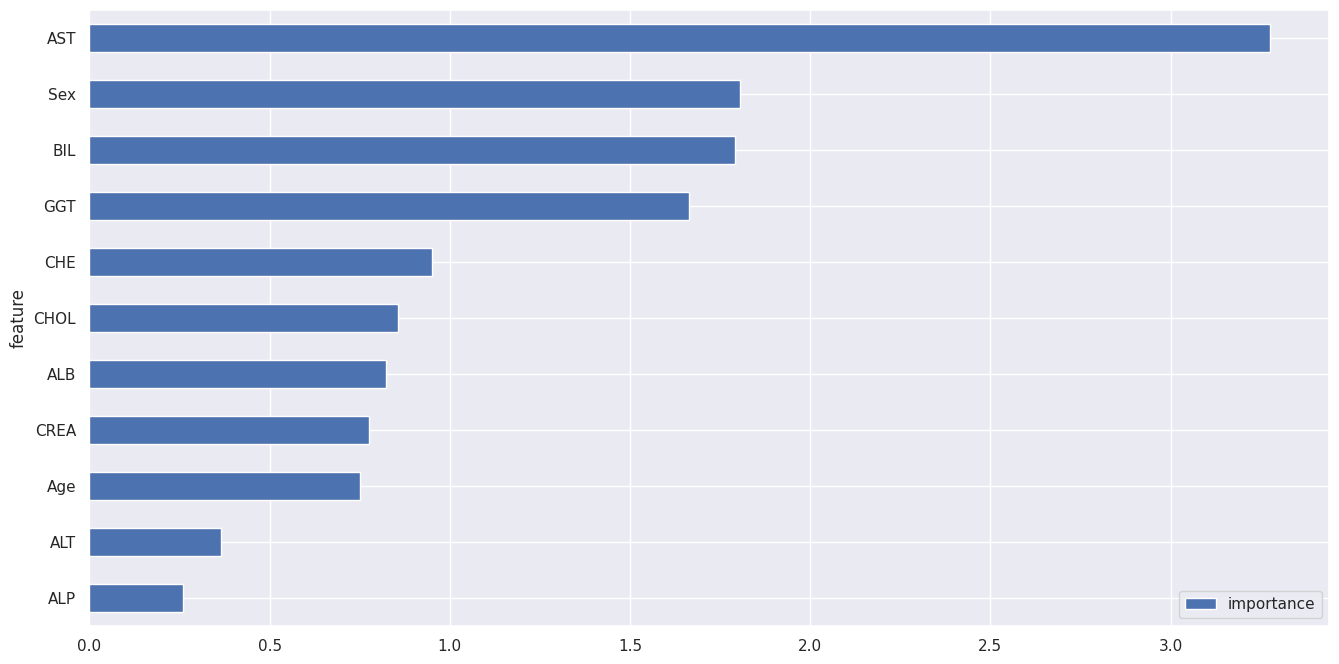

In [112]:
# Checking the Logistic Regression Coefficients
feature_names = ['Age', 'Sex', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE',
       'CHOL', 'CREA', 'GGT']
import math 
w0 = lr.intercept_[0]
w = lr.coef_[0]
feature_importance = pd.DataFrame(feature_names, columns = ["feature"])
feature_importance["importance"] = pow(math.e, w)
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=True)

from sklearn.linear_model import LogisticRegression
ax = feature_importance.plot.barh(x='feature', y='importance')
plt.show()

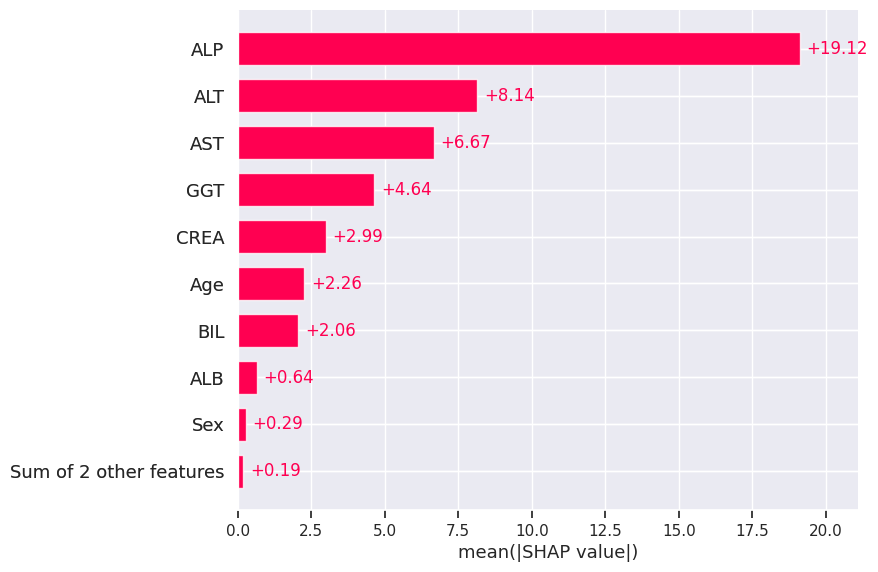

In [110]:
# Calculating shap values for LR
# Fitting the model
lr = LogisticRegression()
lr.fit(X_train, y_train)
masker = shap.maskers.Independent(data = X_test_df)
explainer = shap.LinearExplainer(lr, masker=masker)
shap_values = explainer(X_test_df)
shap.plots.bar(shap_values)

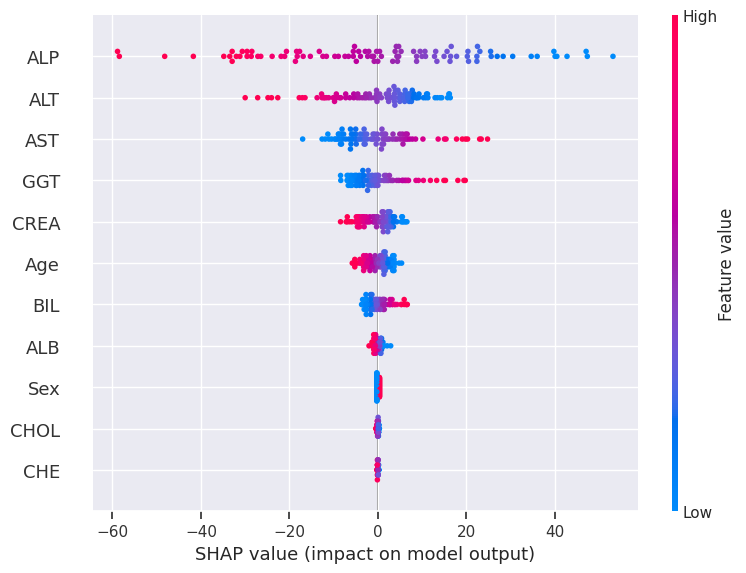

In [111]:
# Plotting SHAP Values
shap.summary_plot(shap_values, features = X_test_df, feature_names = X_test_df.columns)

The SHAP value graph reinforces the information that we got from the above (variable importance) graph. But, the SHAP plot gives us more information about how the magnitude of each variable affects the target. Red represents high value and blue represents low value. As we notice, more than BIL, ASP along with AST and GGT form the most important features. We could infer here that higher the value of ALP test, lower are the chances to Hepatitis, and higher the value of GGT, AST and BIL, higher are the chances to get Hepatitis.

## Interpreting AutoML's best model with tuned hyperparameters

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

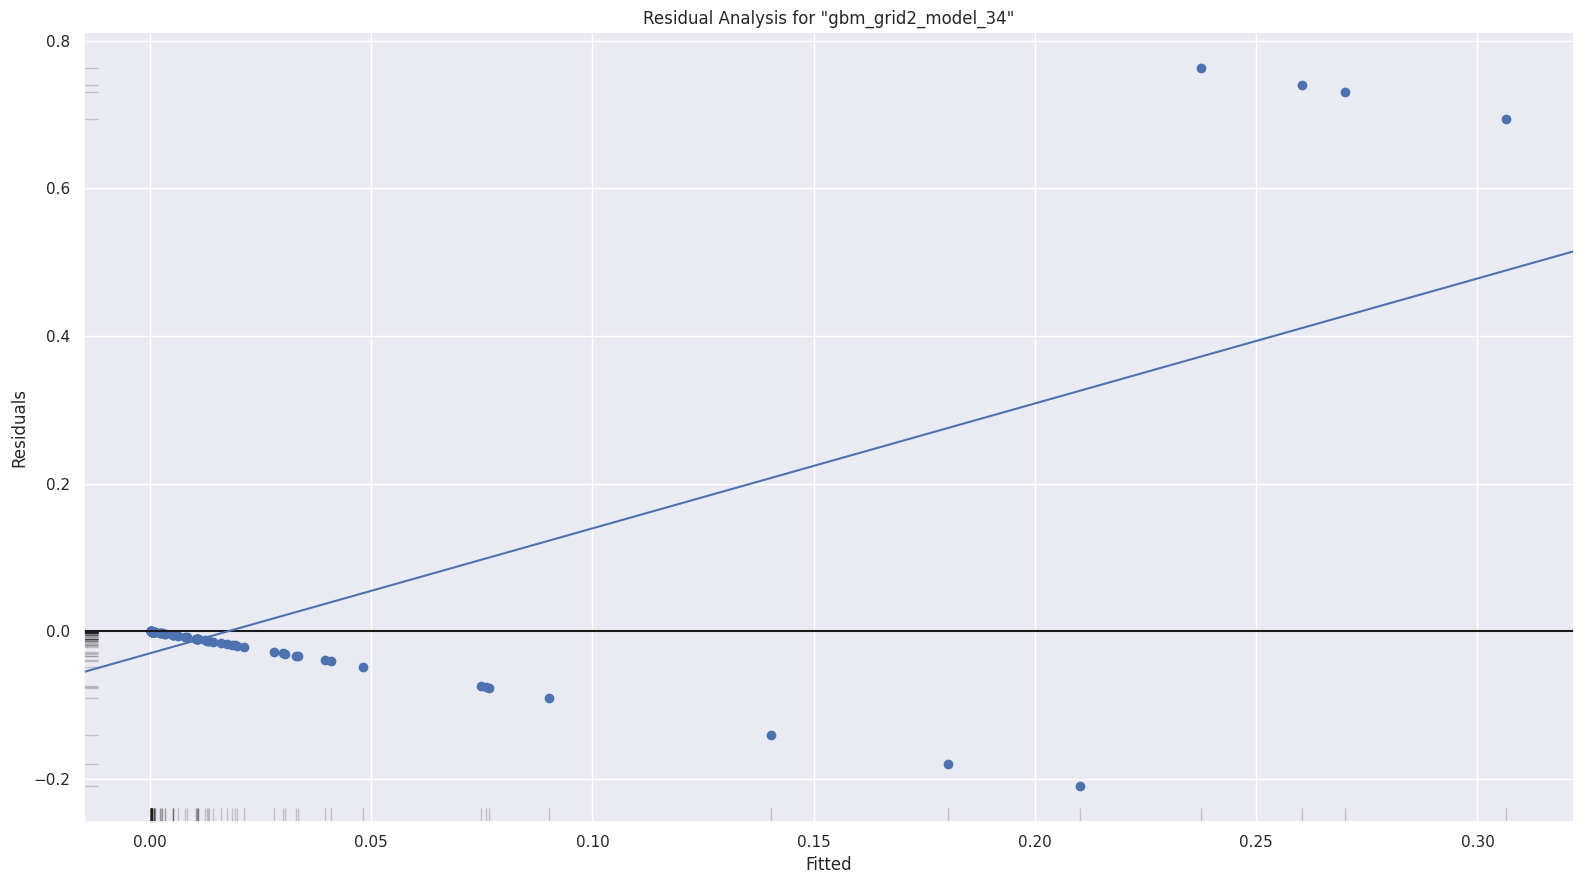

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

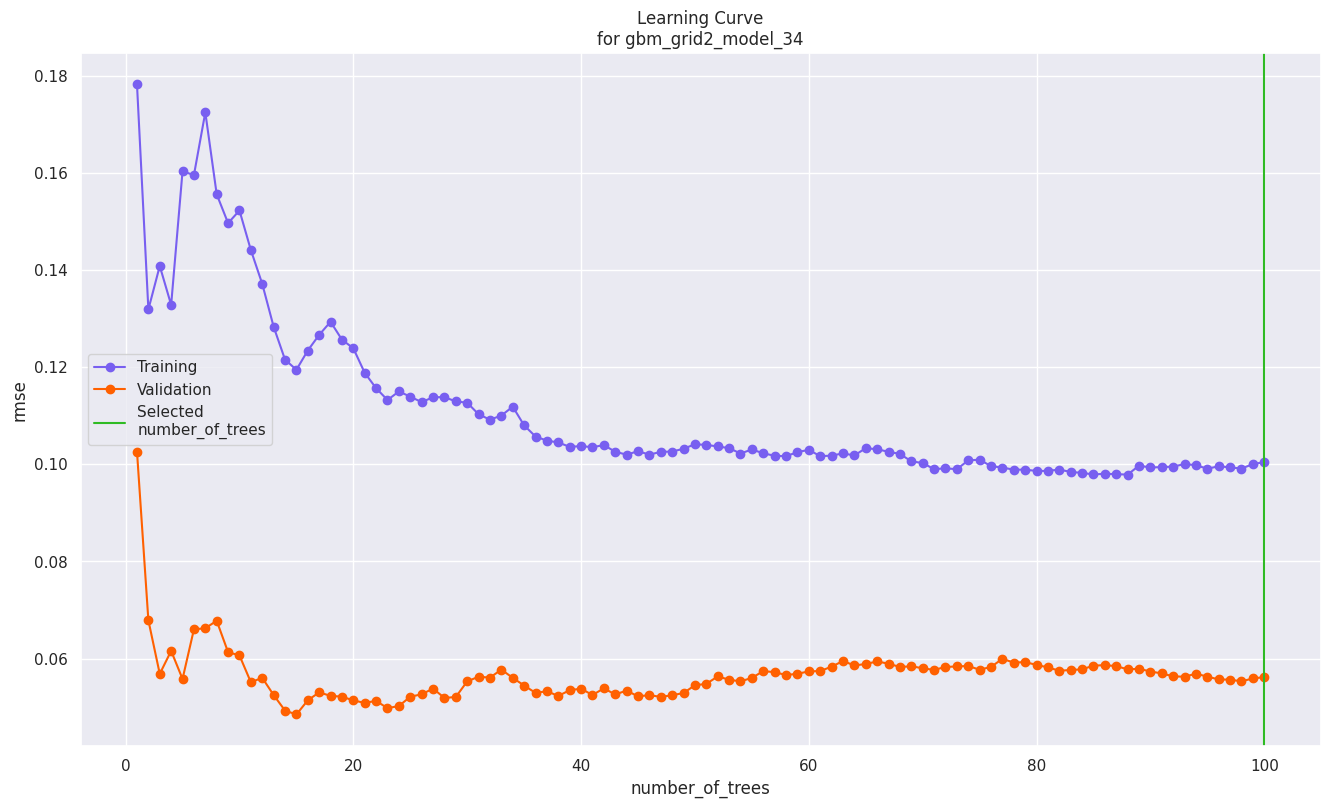

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

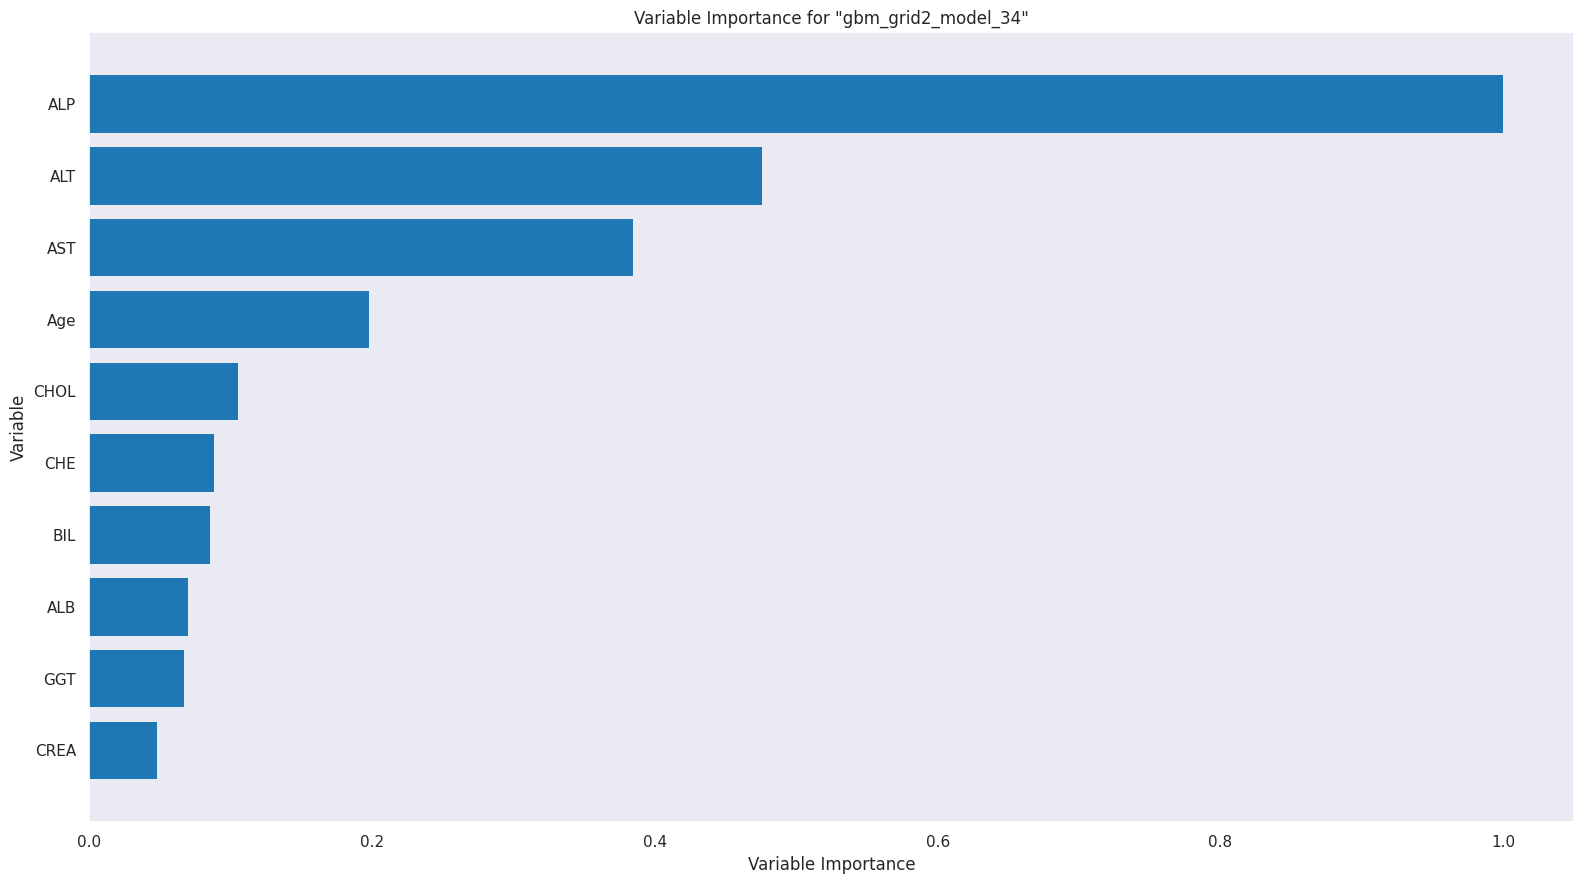

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

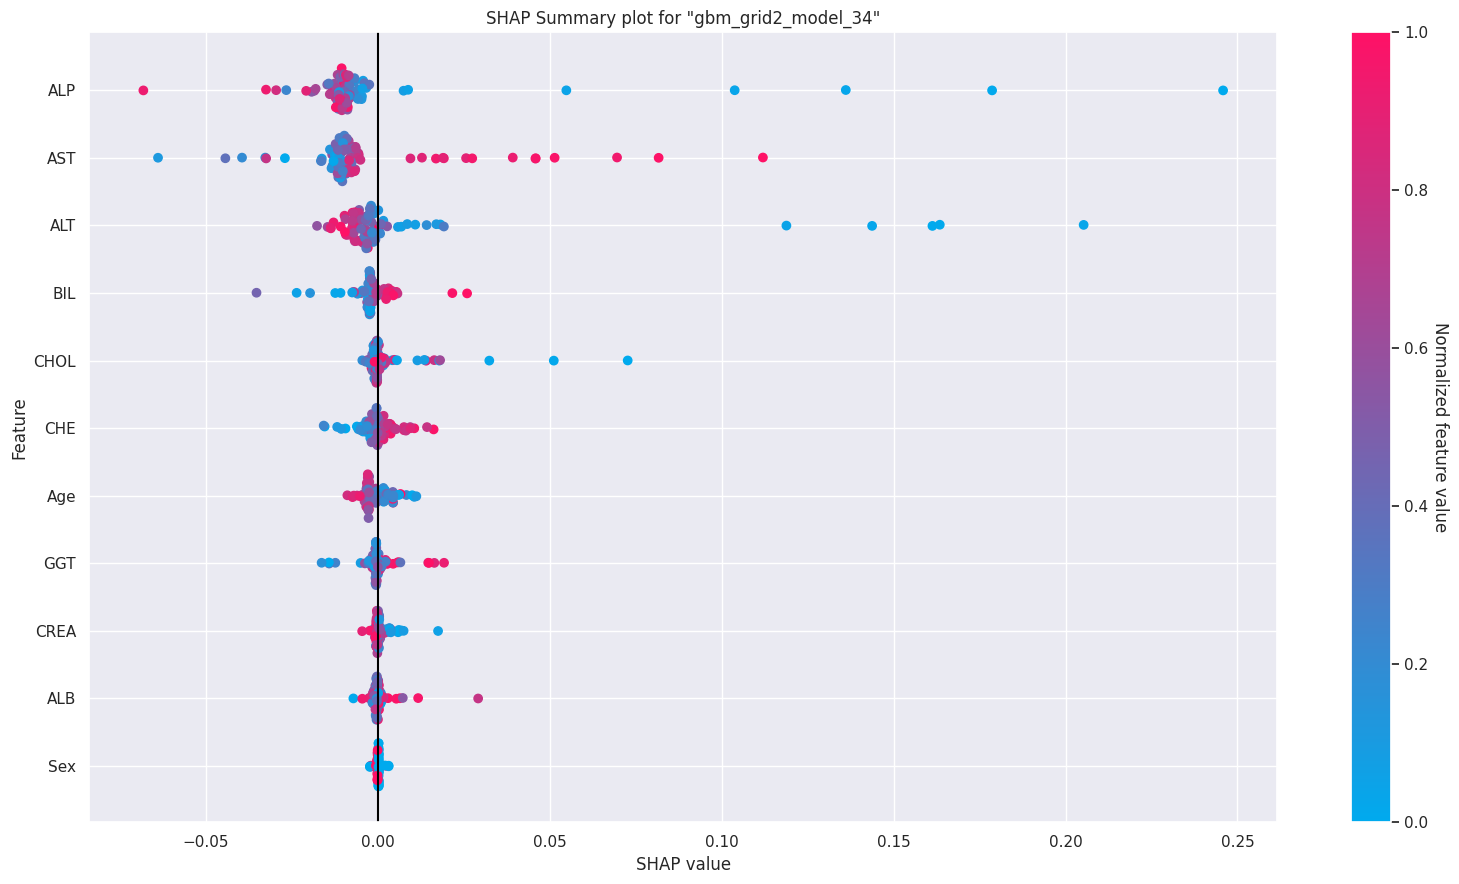

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

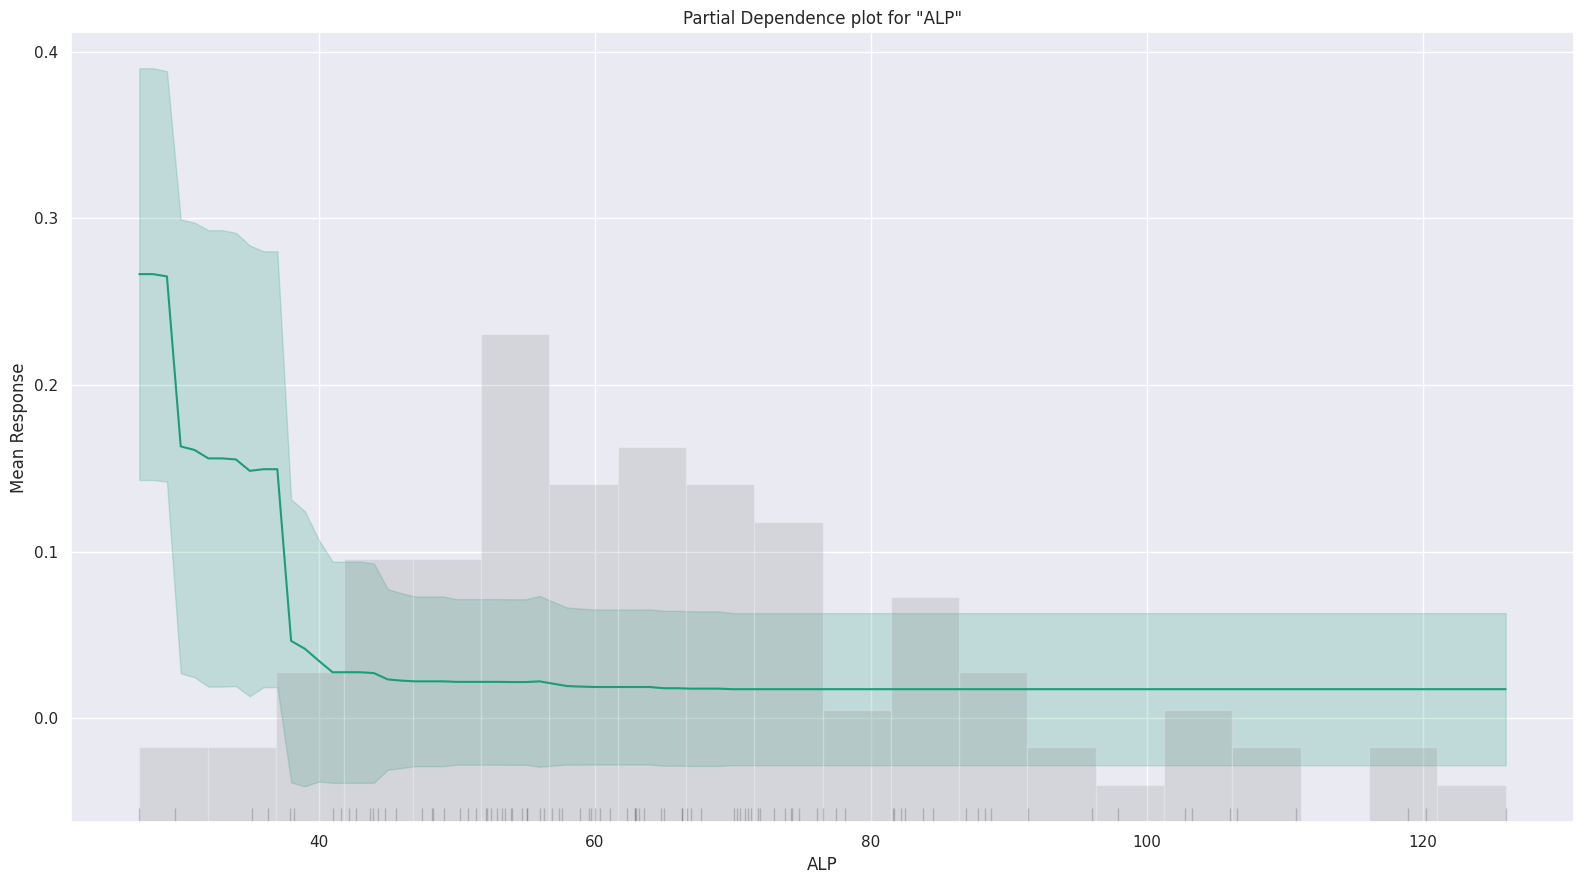

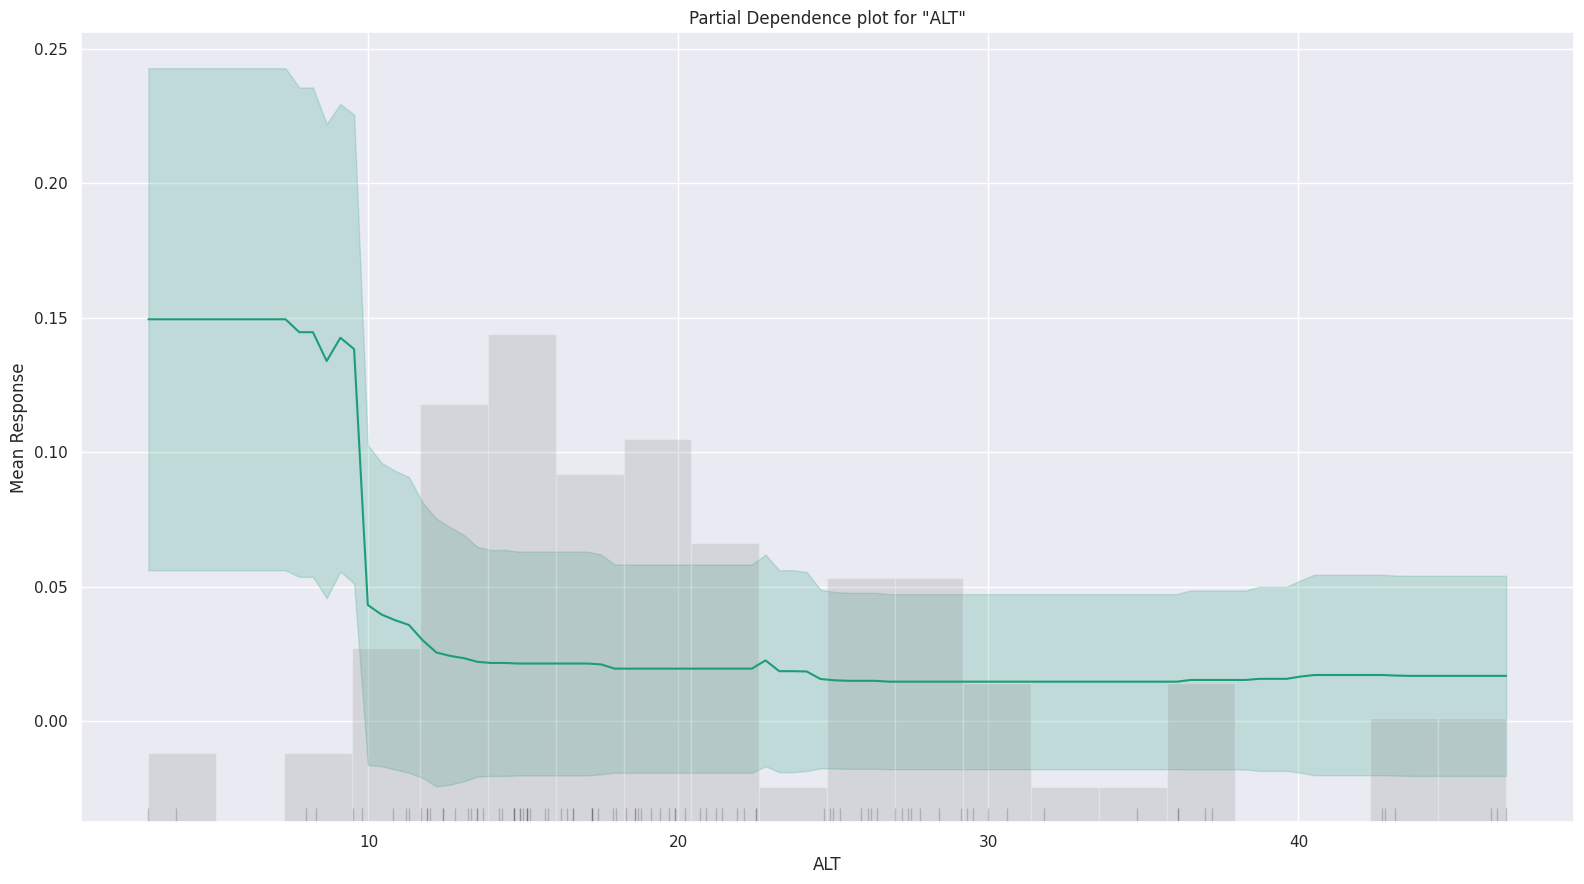

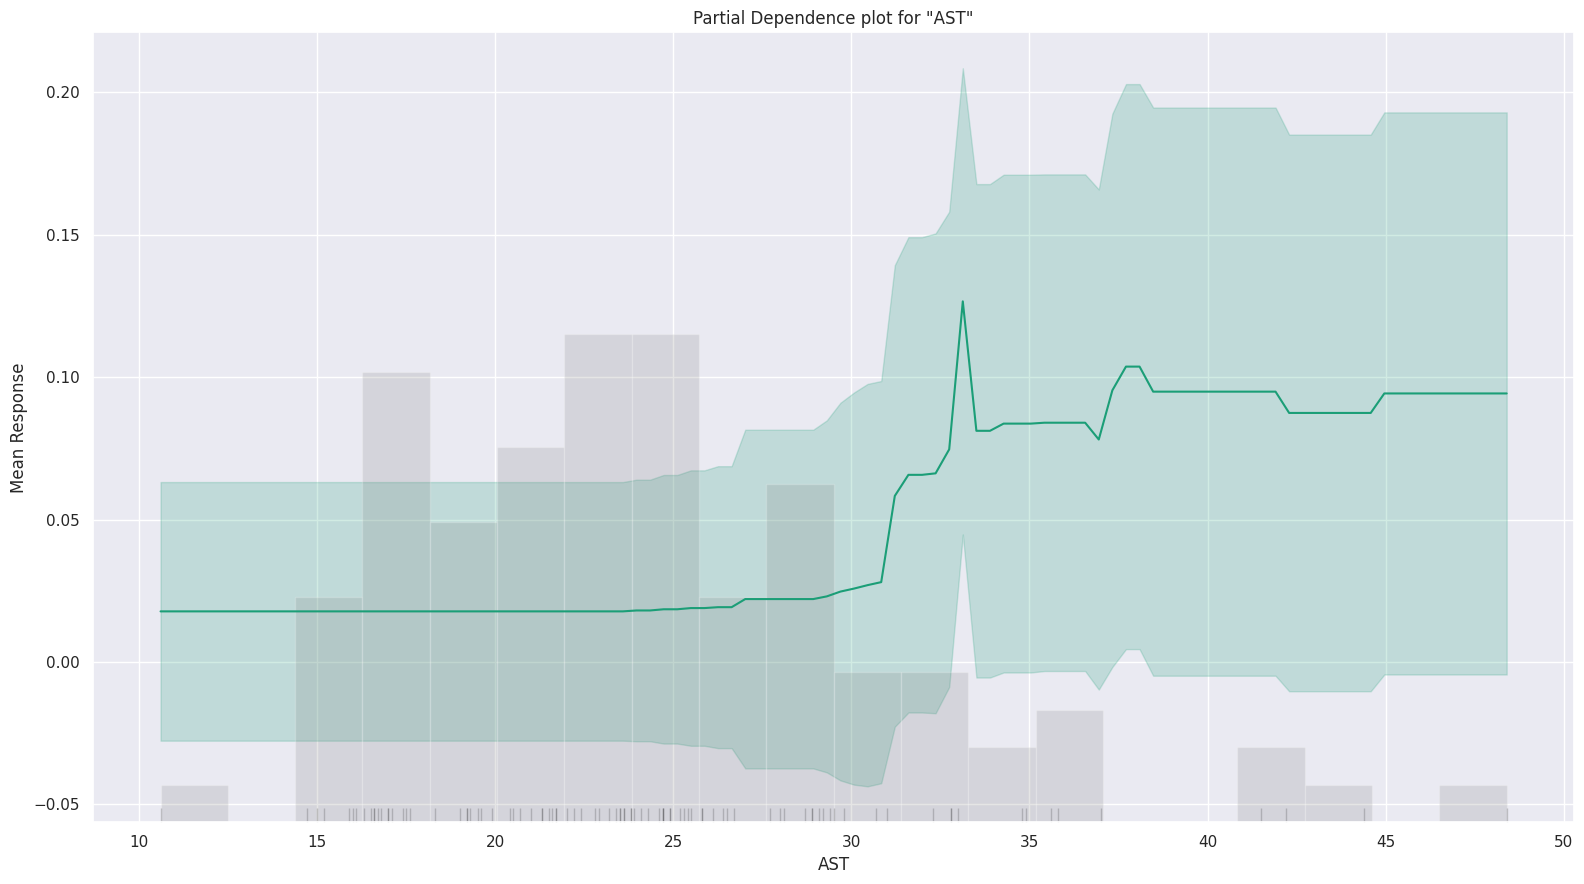

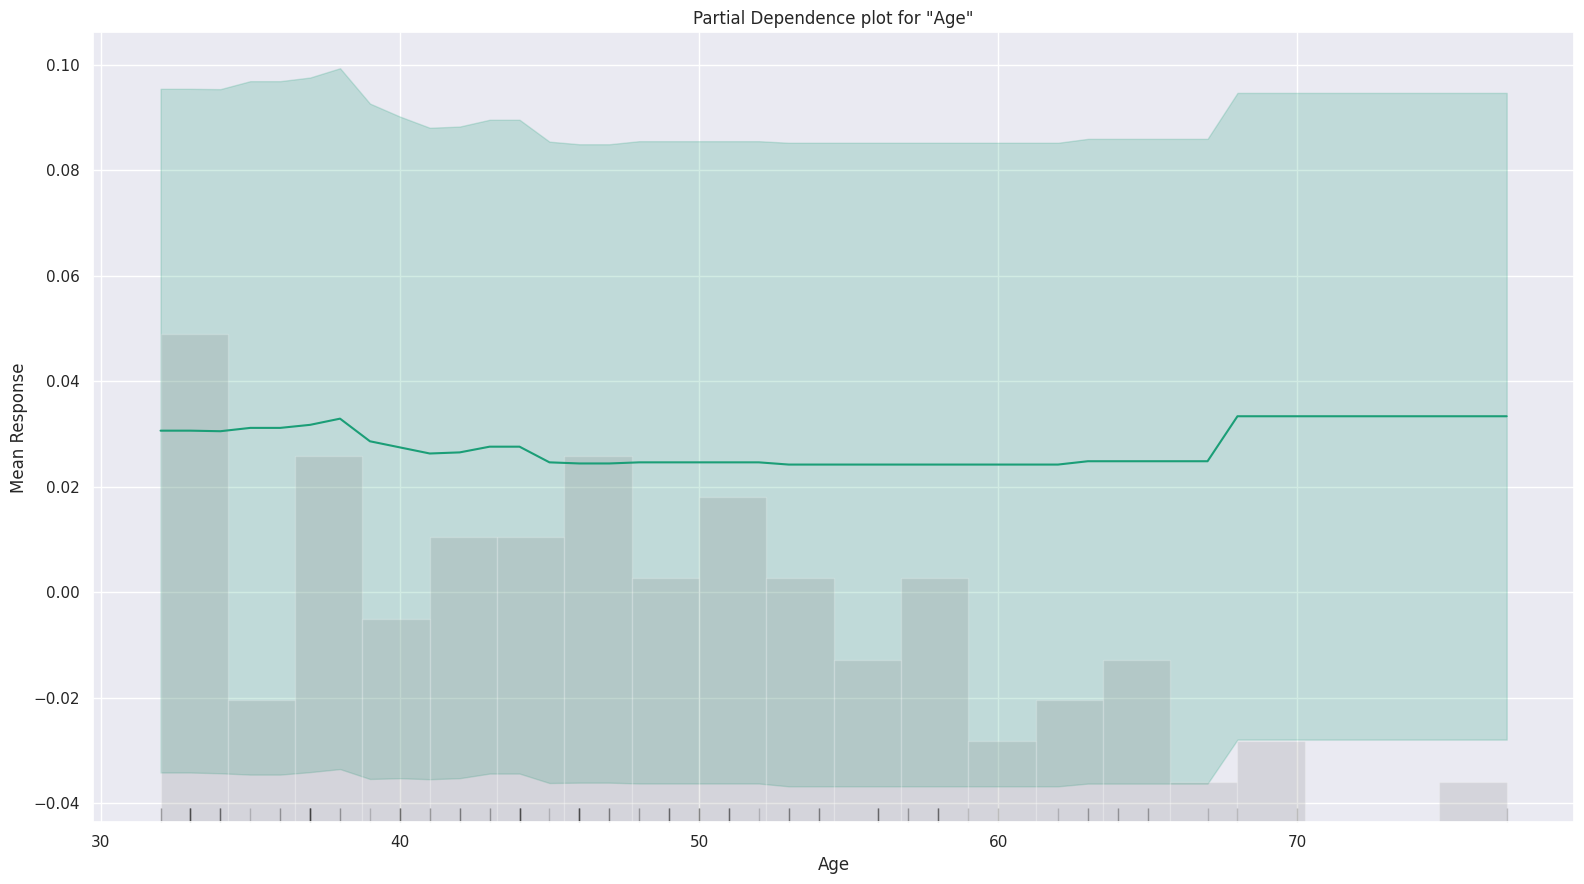

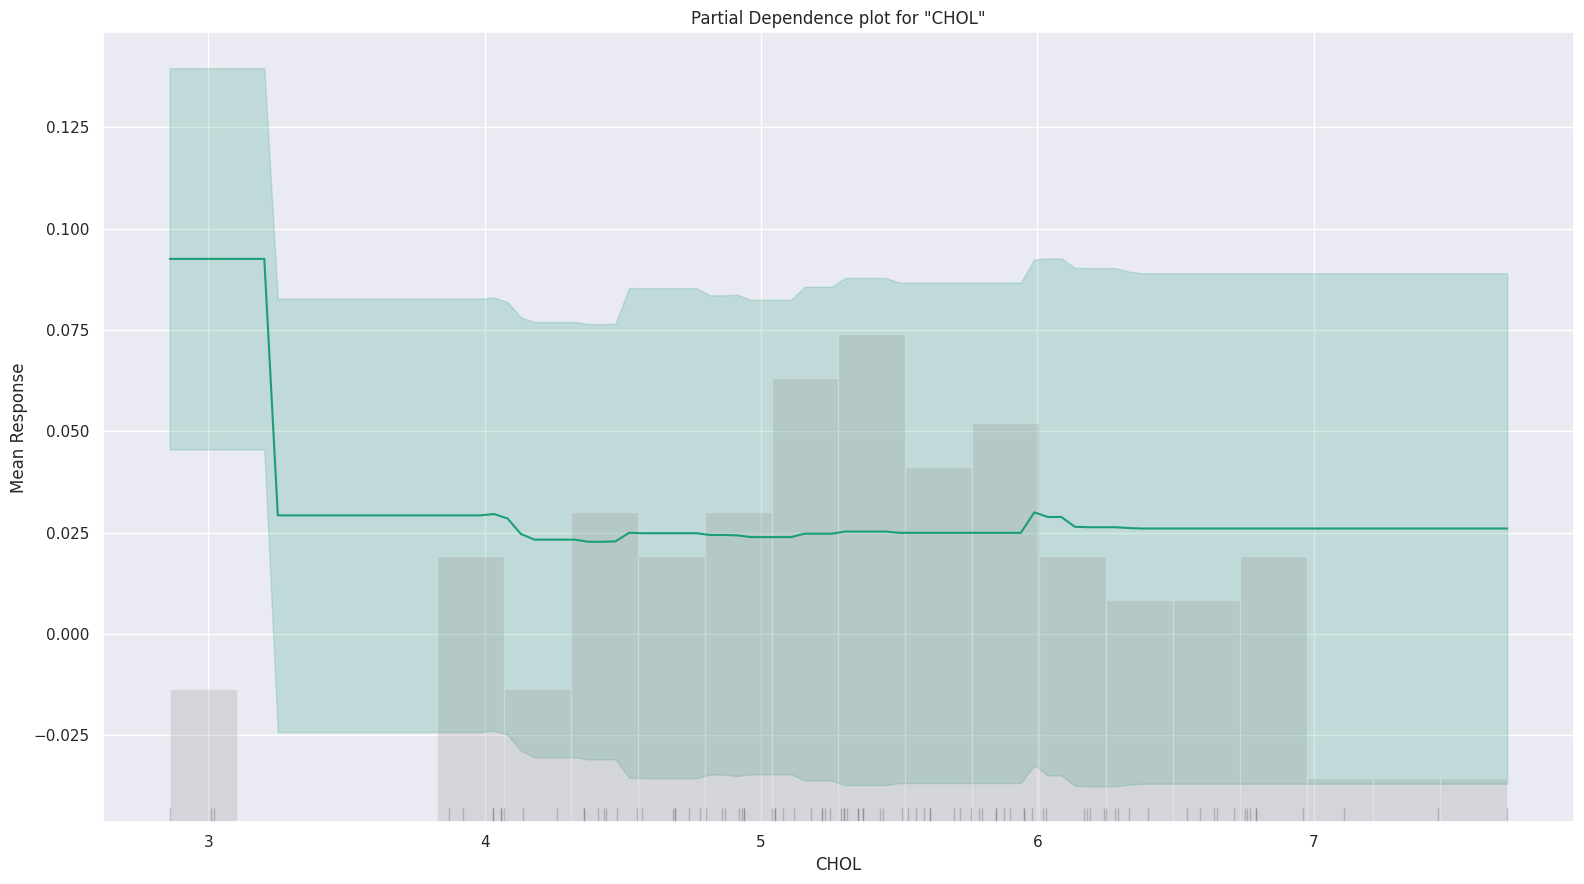

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

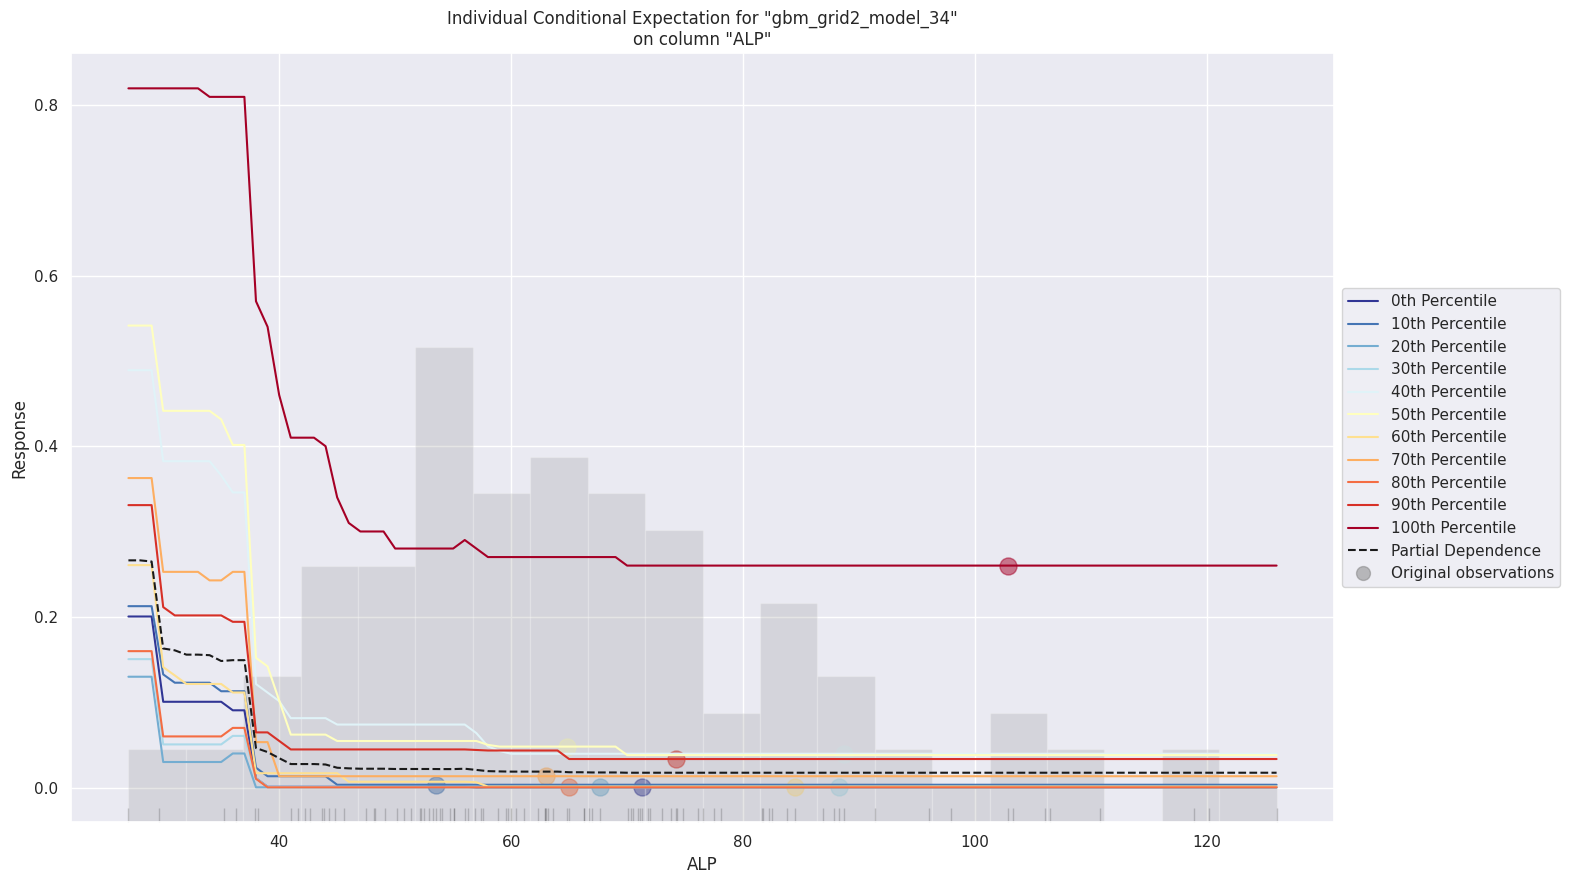

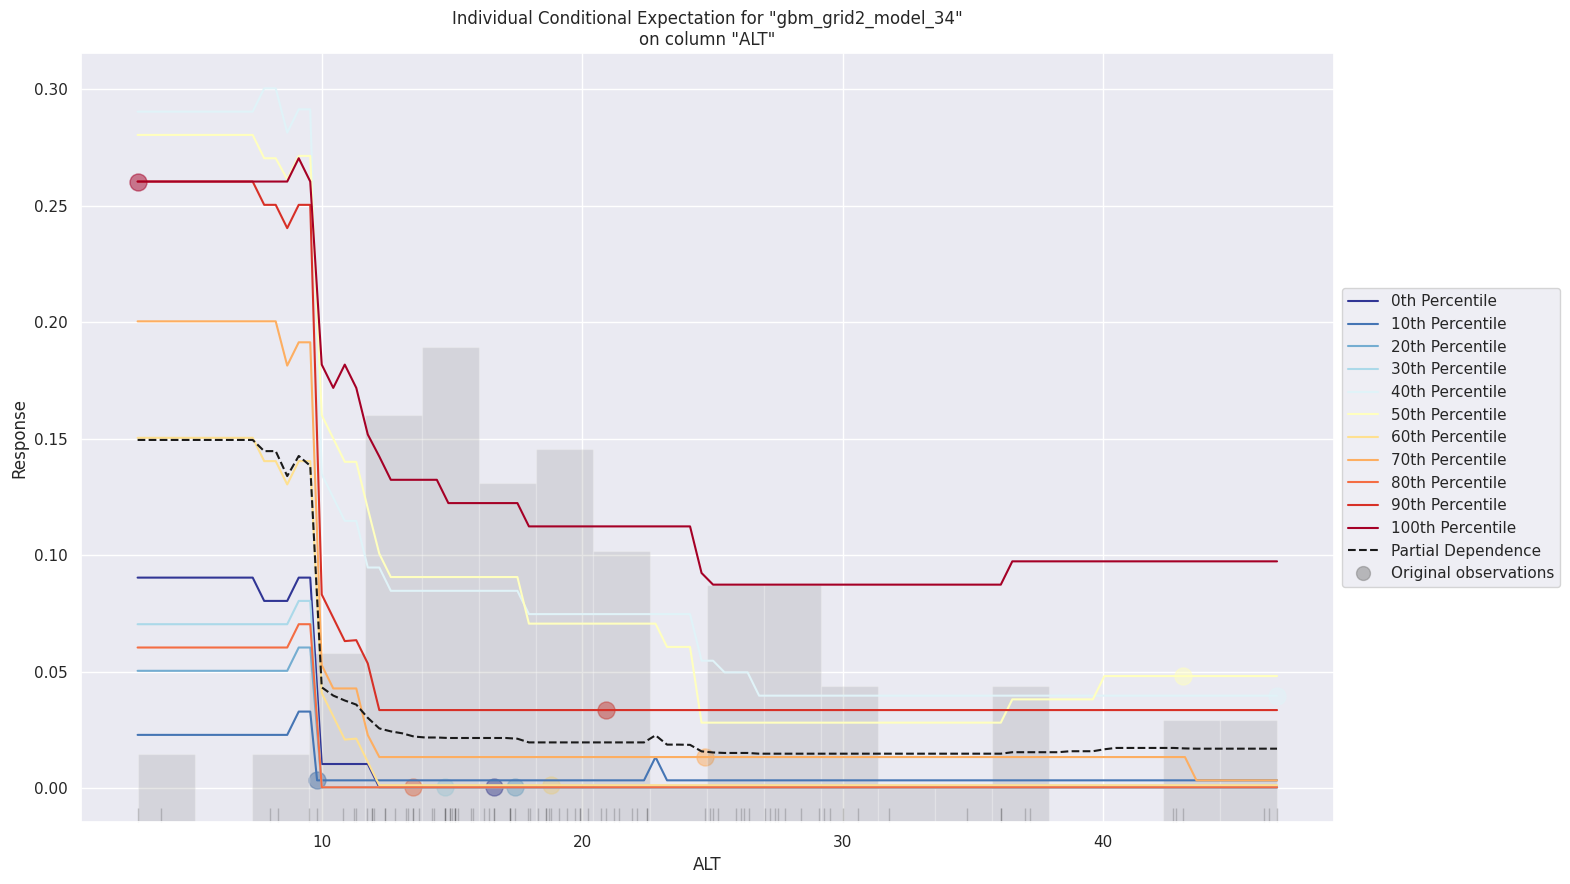

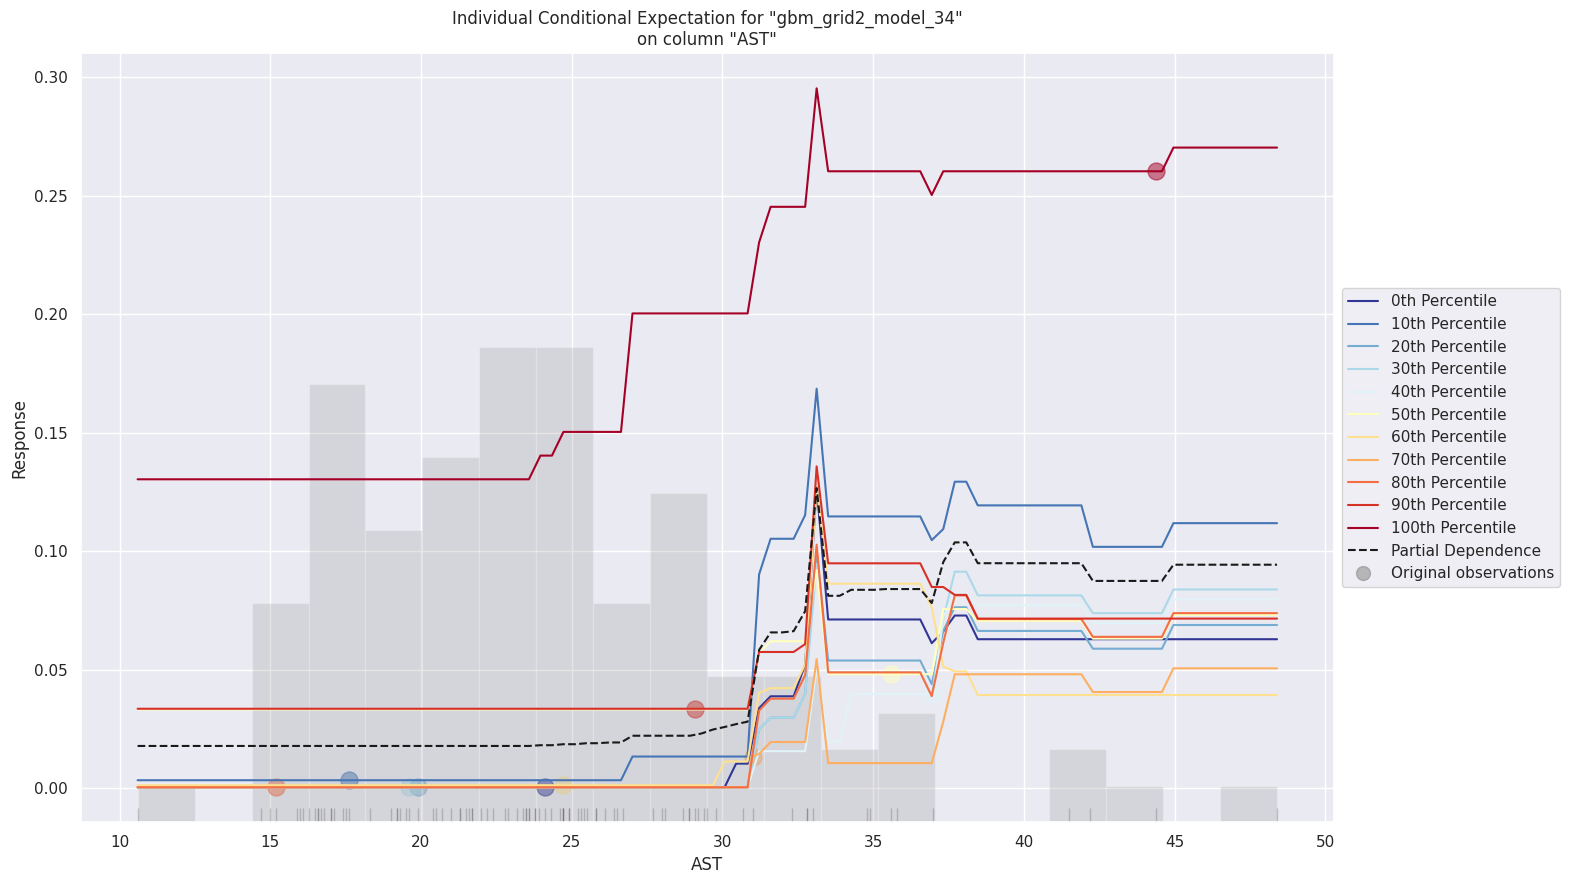

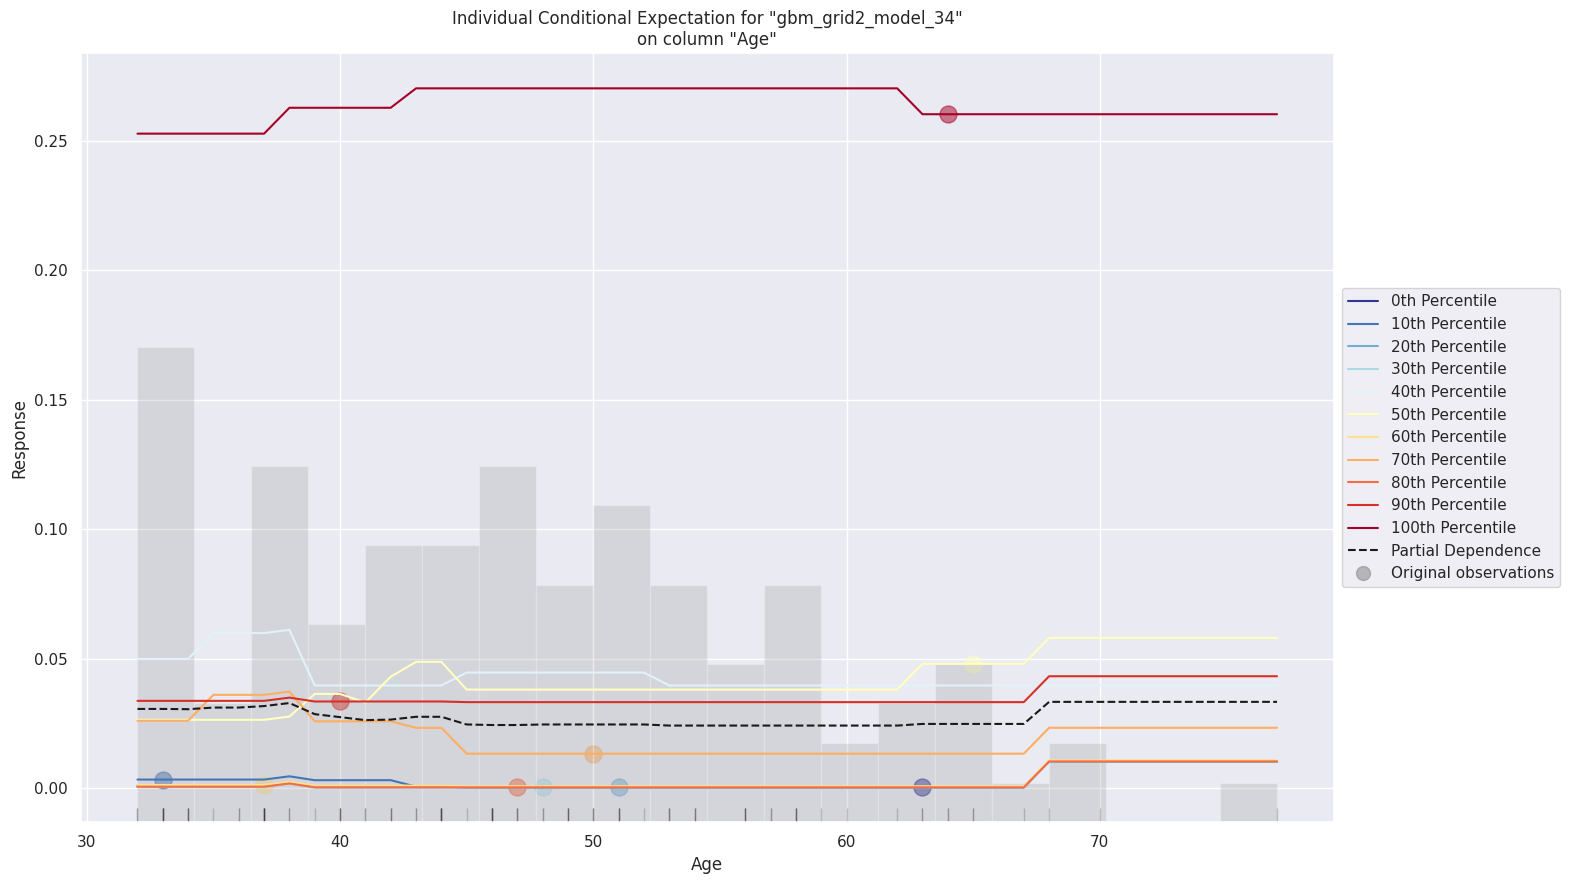

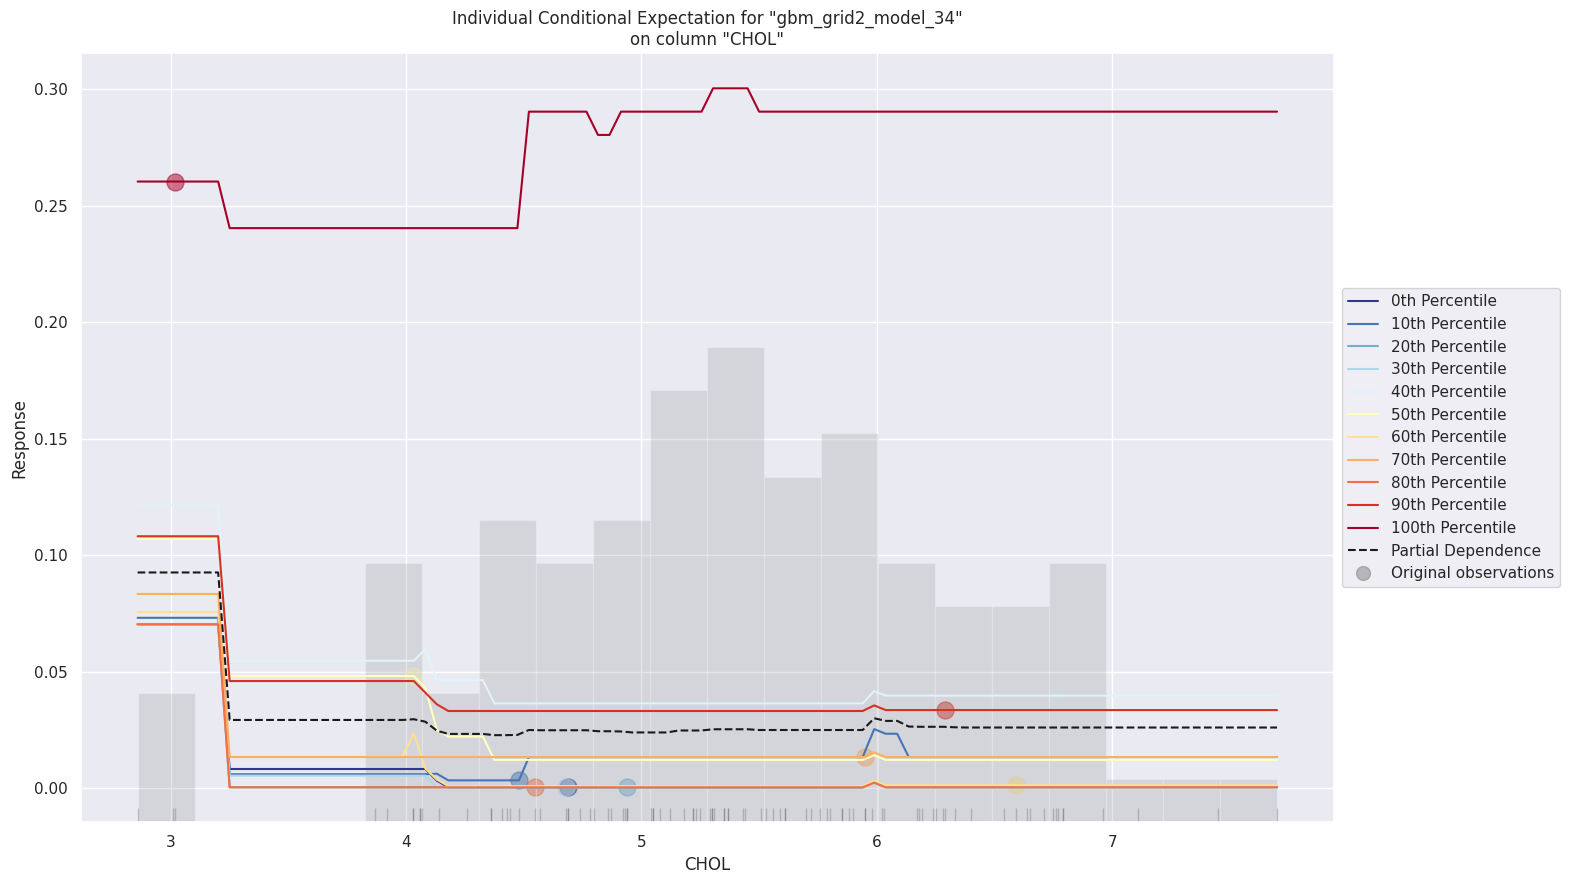

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

In [122]:
best_drf_model.explain(test)  # AutoML Explainability

From the SHAP summary diagram, we can interpret a few conclusions -

1. All the features are listed as per their importance in making the prediction, that is AST is more significant followed by BIL, and so on. Hence, Sex is the least significant predictor in our model.
2. The position on the SHAP value axis indicates the impact the feature has on the prediction either positive or negative. That is, the more the data point is away from the 0.0 shap value - the more its impact is. As we can see ALP and AST has the most impact.
3. The advantage of SHAP analysis over normal feature importance is that we could visualize how the feature is affecting the target at different values. The standard methods tend to overestimate the importance of continuous or high-cardinality categorical variables.

# Conclusion

The Logistic Regression and AutoML's best model with its Hyperparameter's tuned are the best models for this task as they have the highest accuracy compared to the other models tested in this excercise. Also, these models are interpretible i.e. we can actually get to the root of what made this prediction to come to.

# Learning Outcomes

1. Throughout the course, I gained knowledge of the complete lifecycle of a Data Science project, including data preparation and hyperparameter tuning.
2. The most crucial part of a data science project is data preparation, which involves activities like data cleaning, normalization, feature selection, and imputation. It is advisable to invest a significant amount of time in this stage.
3. Although often overlooked, hyperparameter tuning is the second most crucial step after data preparation. It requires time and effort but yields valuable results.
4. It is advisable to train multiple models and select the best ones to deploy, as some algorithms perform better than others on specific tasks.
5. The most valuable lesson from this series of assignments is Model Interpretation or Unboxing the Black Box. I found SHAP to be the most useful method for understanding what influences a model's predictions.

# References

1. https://github.com/aiskunks/YouTube/blob/main/A_Crash_Course_in_Statistical_Learning/Full_ML_Report/Wine-Quality-Analysis.ipynb
2. https://colab.research.google.com/drive/1nfZxDkigeQKojWphOYB-WBey8lGM8zQo#scrollTo=7Jjfi_tpd5dF
3. https://colab.research.google.com/drive/1bTGceIkJRcHHeGjYcxvxghYME4tprsxp#scrollTo=ypWDbdkIJI6g
4. https://docs.h2o.ai/h2o/latest-stable/h2o-docs/grid-search.html
5. https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d